In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
import glob
from scipy.interpolate import CubicSpline

In [2]:
warnings.filterwarnings("ignore")

In [3]:
# Linear Interpolation 
def ends_filler(column):
    if  column.dtype.kind in ['i', 'f']:
            column = first_filler(column)
            column = last_filler(column)
    return column

def first_filler(column):
    if pd.isnull(column.at[0]) or np.isnan(column.at[0]):
        size = len(column) -1
        first_valid_index = 0
        while first_valid_index <= size and (pd.isnull(column.at[first_valid_index]) or np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > size:
            column.at[0] = 0.0
        else:
            column.at[0] = column.at[first_valid_index]
    return column
    
def last_filler(column):
    if pd.isnull(column.at[len(column) -1]) or np.isnan(column.at[len(column) -1]):  
        last_valid_index = len(column) -1
        while last_valid_index >= 0 and (pd.isnull(column.at[last_valid_index]) or np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < 0:
            column.at[len(column) -1] = 0.0
        else:
            column.at[len(column) -1] = column.at[last_valid_index]
    return column
    
def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos > 0 and pos < size:
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos > 0 and pos < size:
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def linear_filler(column):
    if column.isnull().any():
        for i, value in enumerate(column):
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                linear_a = (column.at[end] - column.at[start])/(end - start)
                linear_b = column.at[start] - linear_a*start
                for x in gap:
                    column.at[x] = linear_a*x + linear_b
    return column 

In [4]:
def centered_moving_average(column, window_action, window_size):
    
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)
    moving_averages = []

    for i in range(start_index, end_index + 1):
        start = max(0, i - window_size)
        end = min(data_length, i + window_size + 1)
        window = data[start:end]
        moving_averages.append(np.mean(window))
        
    modified_data = data.copy()
    modified_data[start_index:end_index + 1] = moving_averages
    modified_column = pd.Series(modified_data, name=column.name)

    return modified_column

In [5]:
def read_csv_replace_missing_by_linear(file_path, skiped_rows):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > 0:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = ends_filler(df[col])
                df[col] = linear_filler(df[col]) 
            i += 1
        return df

In [6]:
df = pd.read_csv("consumo_cimento_mensal.csv")
df

Ano  Rondônia - Consumo de Cimento (t)  \
0    2003-01                             13.867   
1    2003-02                             10.777   
2    2003-03                             13.888   
3    2003-04                             11.859   
4    2003-05                             14.431   
..       ...                                ...   
235  2022-08                             49.066   
236  2022-09                             49.850   
237  2022-10                             43.733   
238  2022-11                             40.078   
239  2022-12                                NaN   

     Acre - Consumo de Cimento (t)  Amazonas - Consumo de Cimento (t)  \
0                            3.260                             28.193   
1                            2.191                             31.226   
2                            2.154                             33.484   
3                            2.643                             31.596   
4                            2.546                             32.919   
..                             ...                                ...   
235                         21.748                             66.077   
236                         20.032                             58.590   
237                         18.573                             58.793   
238                         15.493                             53.509   
239                            NaN                                NaN   

     Roraima - Consumo de Cimento (t)  Pará - Consumo de Cimento (t)  \
0                               6.920                         84.701   
1                               7.476                         80.221   
2                               8.659                         76.122   
3                               7.259                         76.544   
4                               6.786                         83.445   
..                                ...                            ...   
235                             9.133                        156.442   
236                            10.622                        145.777   
237                            10.300                        139.233   
238                            10.258                        142.025   
239                               NaN                            NaN   

     Amapá - Consumo de Cimento (t)  Totins-01 - Consumo de Cimento (t)  \
0                            10.392                              17.555   
1                             6.857                              14.976   
2                             7.011                              13.334   
3                             7.122                              15.173   
4                             5.267                              18.728   
..                              ...                                 ...   
235                          13.208                              54.154   
236                          13.476                              55.664   
237                          11.236                              52.320   
238                          13.549                              43.036   
239                             NaN                                 NaN   

     Mahão -01- Consumo de Cimento (t)  Piauí - Consumo de Cimento (t)  ...  \
0                               43.342                          21.844  ...   
1                               28.663                          15.814  ...   
2                               27.900                          16.067  ...   
3                               25.739                          14.938  ...   
4                               30.203                          17.765  ...   
..                                 ...                             ...  ...   
235                            102.698                          77.776  ...   
236                             98.133                          72.377  ...   
237                             94.964    

In [8]:
df = read_csv_replace_missing_by_linear("consumo_cimento_mensal.csv",0)
df

Ano  Rondônia - Consumo de Cimento (t)  \
0    2003-01                             13.867   
1    2003-02                             10.777   
2    2003-03                             13.888   
3    2003-04                             11.859   
4    2003-05                             14.431   
..       ...                                ...   
235  2022-08                             49.066   
236  2022-09                             49.850   
237  2022-10                             43.733   
238  2022-11                             40.078   
239  2022-12                             40.078   

     Acre - Consumo de Cimento (t)  Amazonas - Consumo de Cimento (t)  \
0                            3.260                             28.193   
1                            2.191                             31.226   
2                            2.154                             33.484   
3                            2.643                             31.596   
4                            2.546                             32.919   
..                             ...                                ...   
235                         21.748                             66.077   
236                         20.032                             58.590   
237                         18.573                             58.793   
238                         15.493                             53.509   
239                         15.493                             53.509   

     Roraima - Consumo de Cimento (t)  Pará - Consumo de Cimento (t)  \
0                               6.920                         84.701   
1                               7.476                         80.221   
2                               8.659                         76.122   
3                               7.259                         76.544   
4                               6.786                         83.445   
..                                ...                            ...   
235                             9.133                        156.442   
236                            10.622                        145.777   
237                            10.300                        139.233   
238                            10.258                        142.025   
239                            10.258                        142.025   

     Amapá - Consumo de Cimento (t)  Totins-01 - Consumo de Cimento (t)  \
0                            10.392                              17.555   
1                             6.857                              14.976   
2                             7.011                              13.334   
3                             7.122                              15.173   
4                             5.267                              18.728   
..                              ...                                 ...   
235                          13.208                              54.154   
236                          13.476                              55.664   
237                          11.236                              52.320   
238                          13.549                              43.036   
239                          13.549                              43.036   

     Mahão -01- Consumo de Cimento (t)  Piauí - Consumo de Cimento (t)  ...  \
0                               43.342                          21.844  ...   
1                               28.663                          15.814  ...   
2                               27.900                          16.067  ...   
3                               25.739                          14.938  ...   
4                               30.203                          17.765  ...   
..                                 ...                             ...  ...   
235                            102.698                          77.776  ...   
236                             98.133                          72.377  ...   
237                             94.964    

In [9]:
def plot_column(column, color):
    plt.figure(figsize=(12, 6))
    plt.plot(column.index, column.values, color=color)
    plt.xlabel(column.index.name)
    plt.ylabel('Toneladas de Cimento')
    plt.title(column.name)  # Set the column name as the graph title
    plt.xticks(rotation=45)
    plt.show()

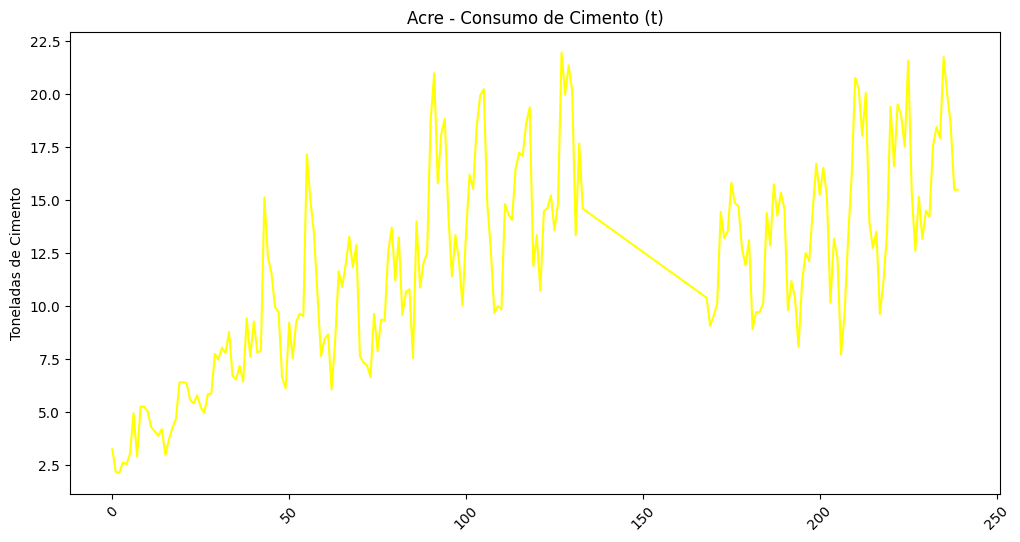

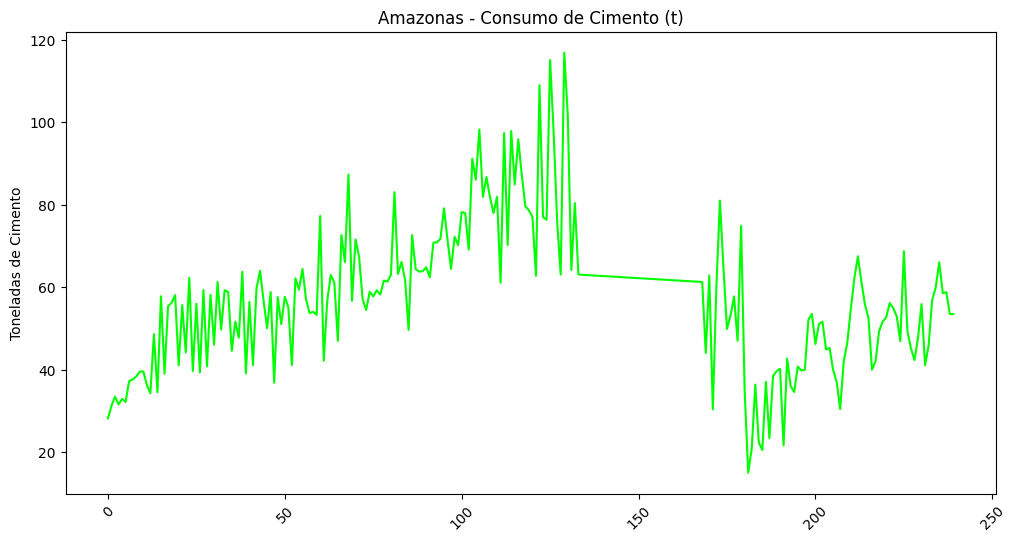

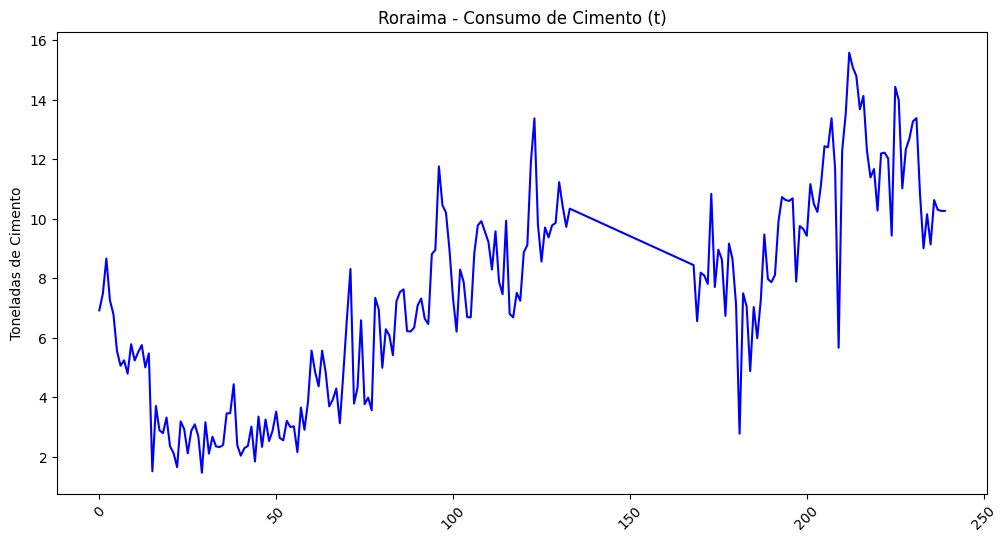

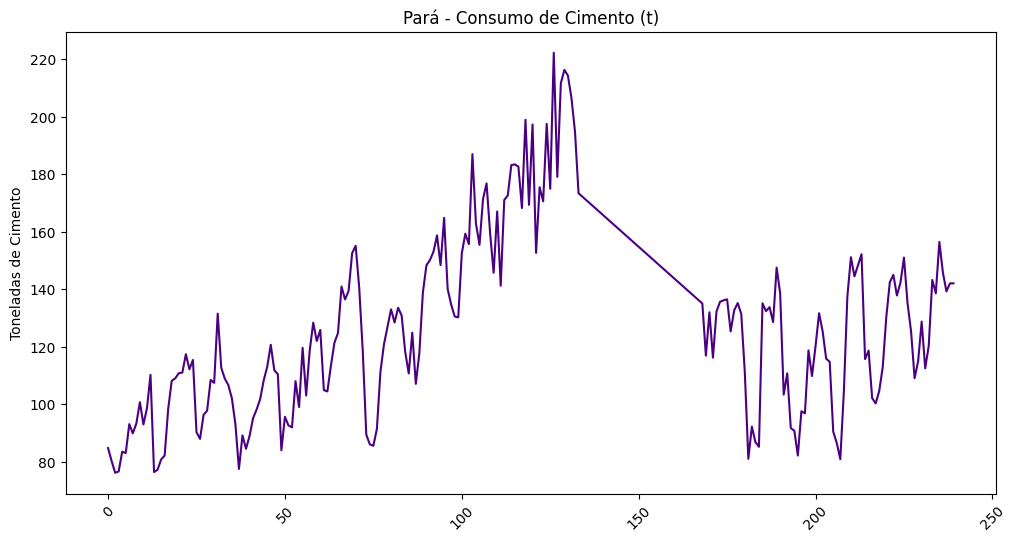

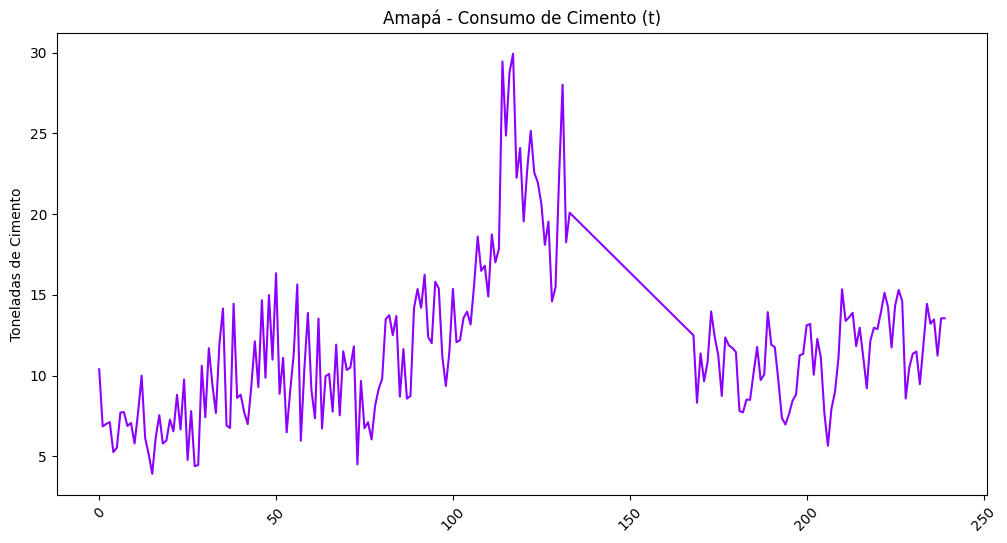

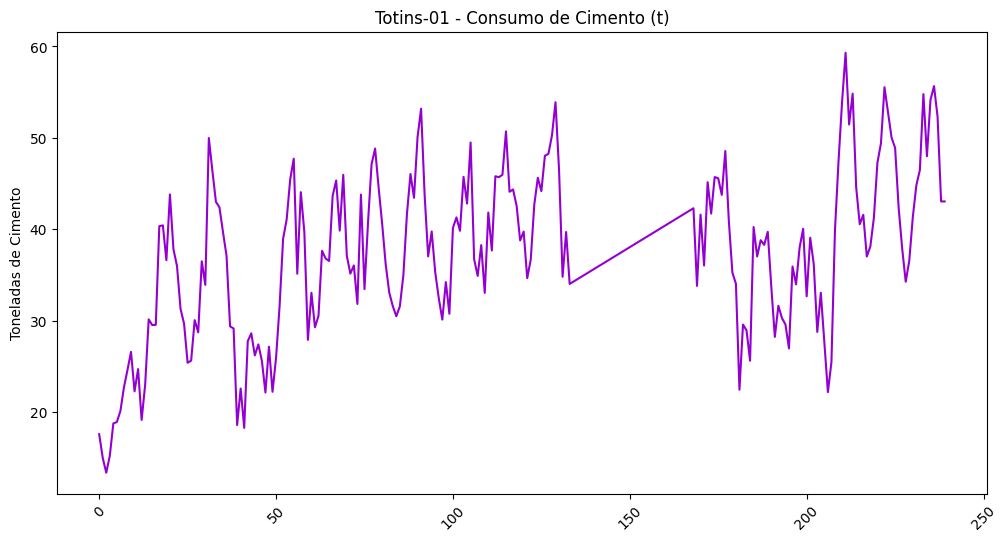

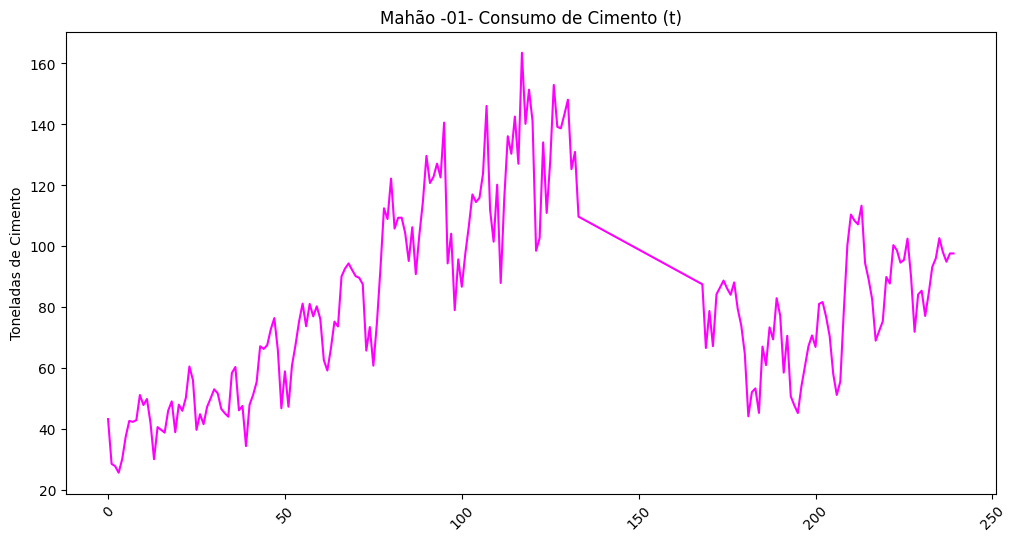

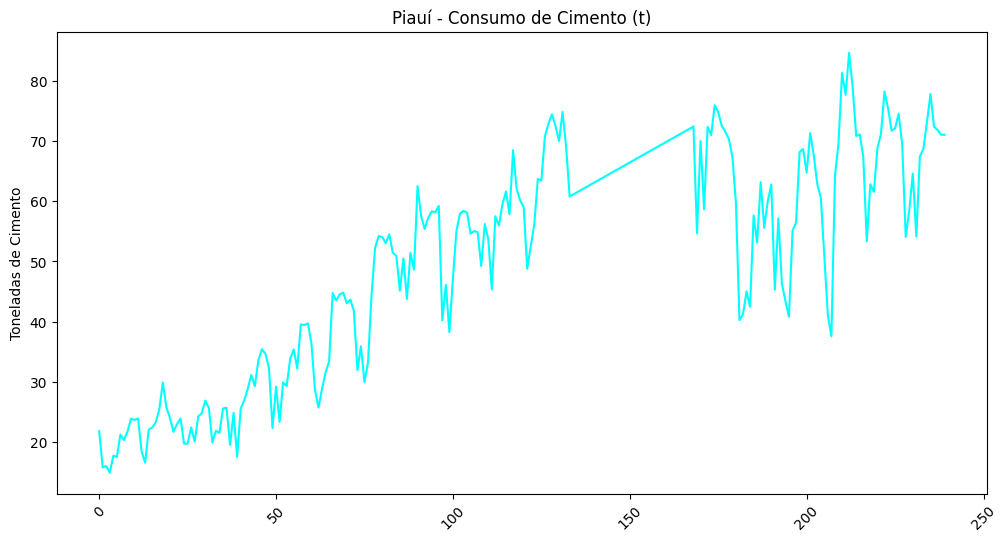

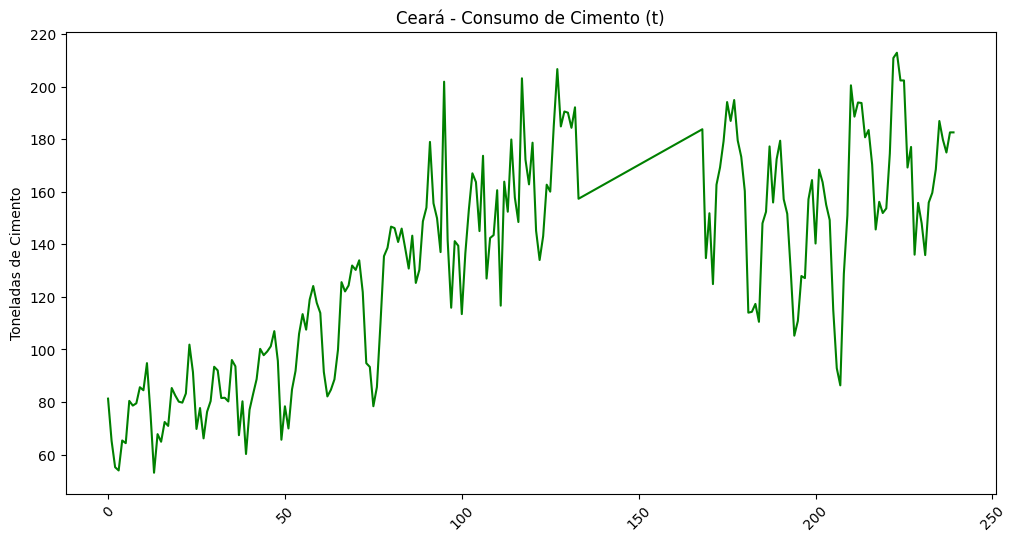

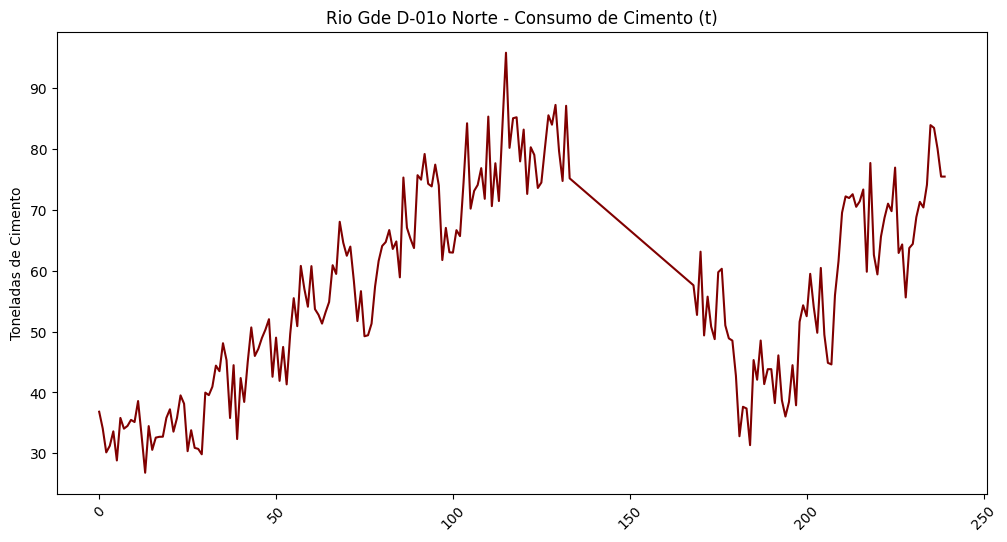

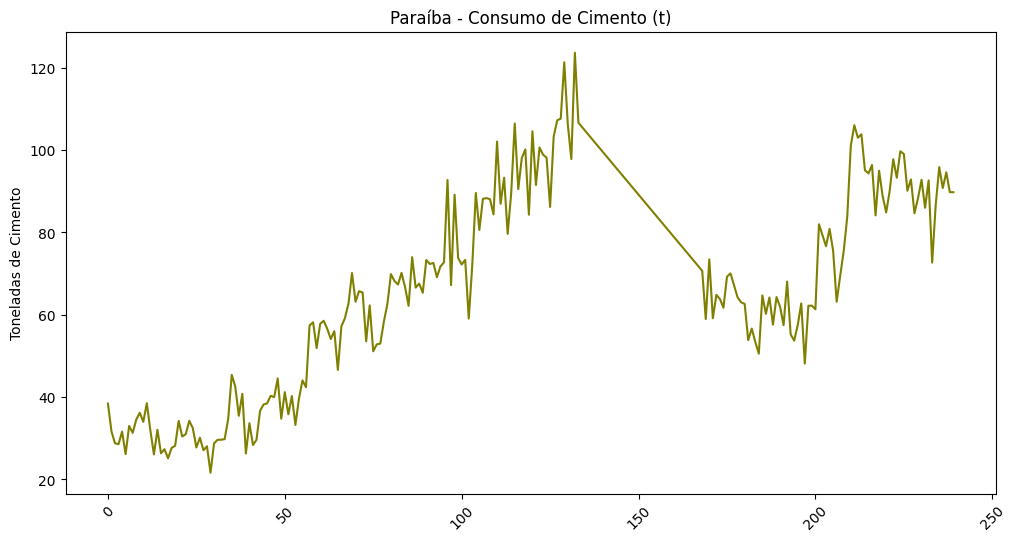

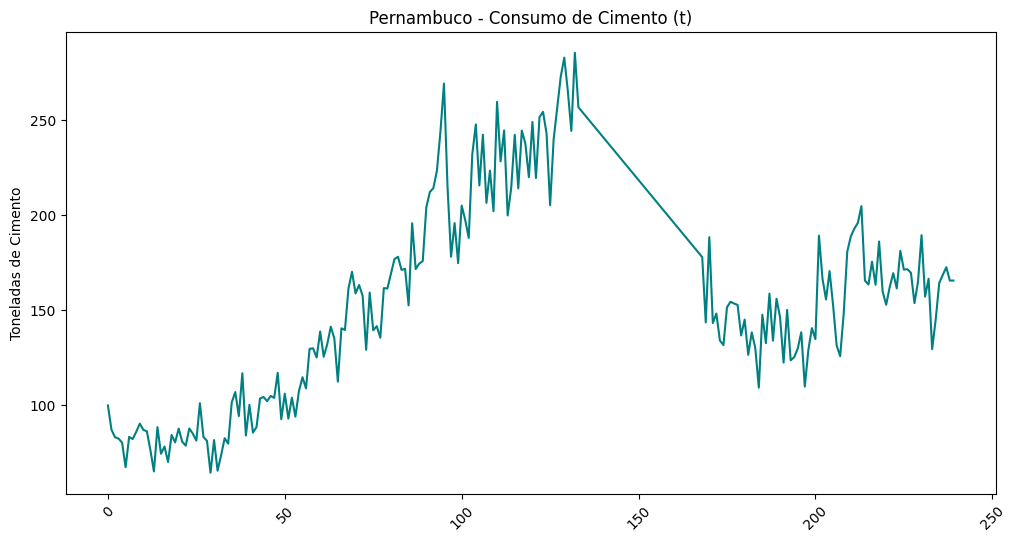

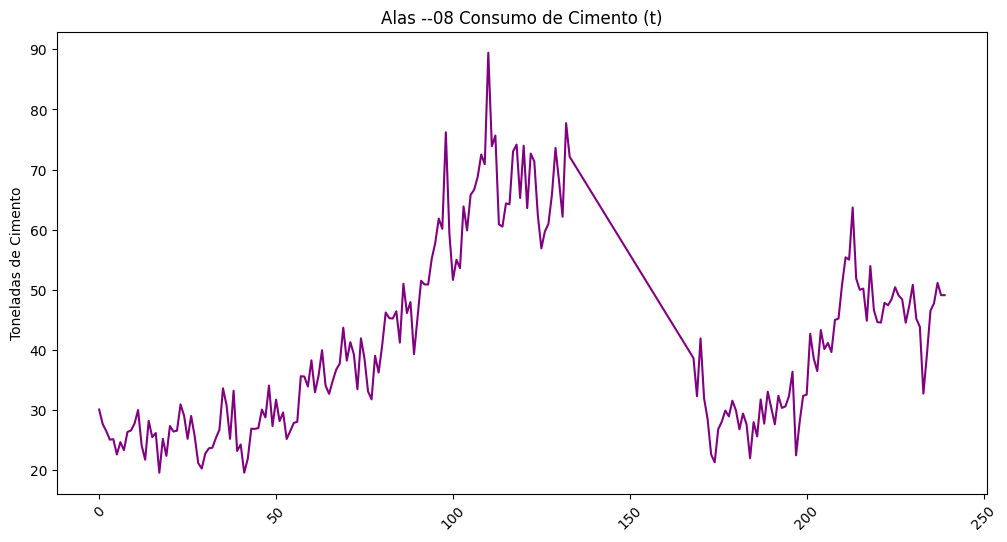

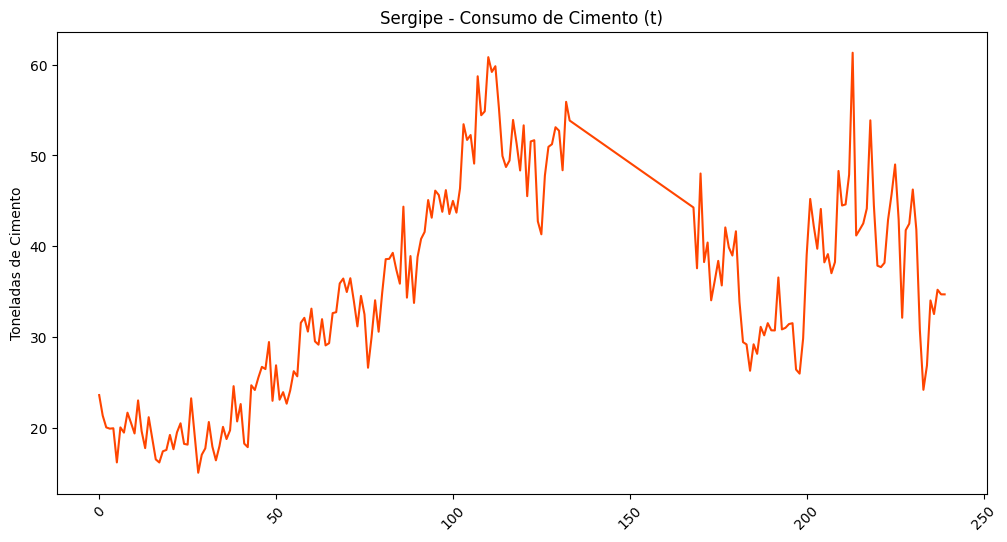

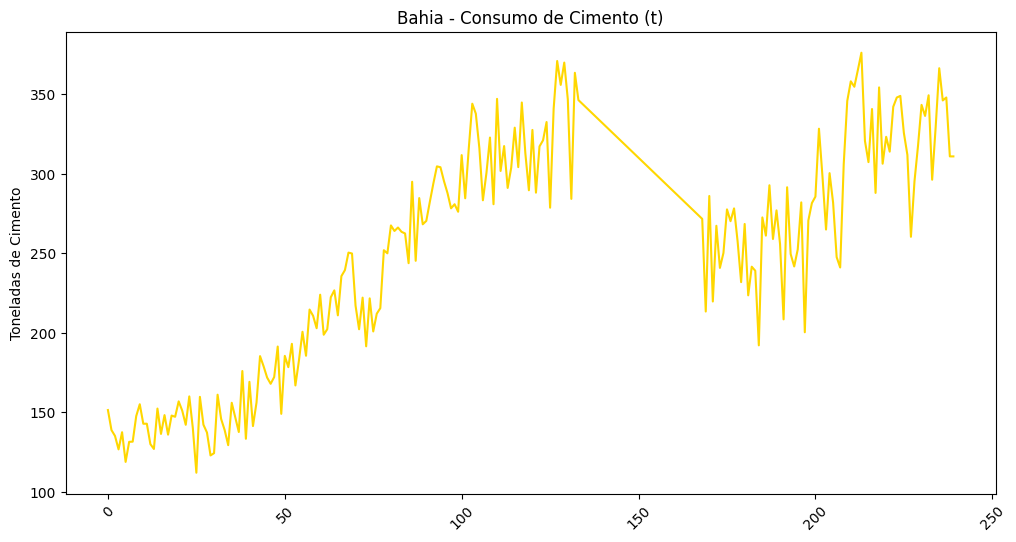

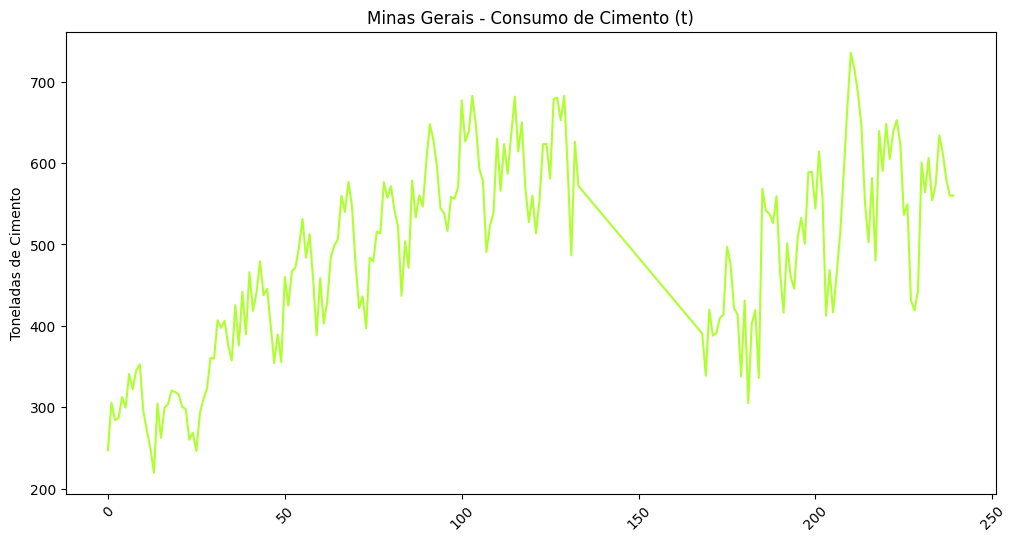

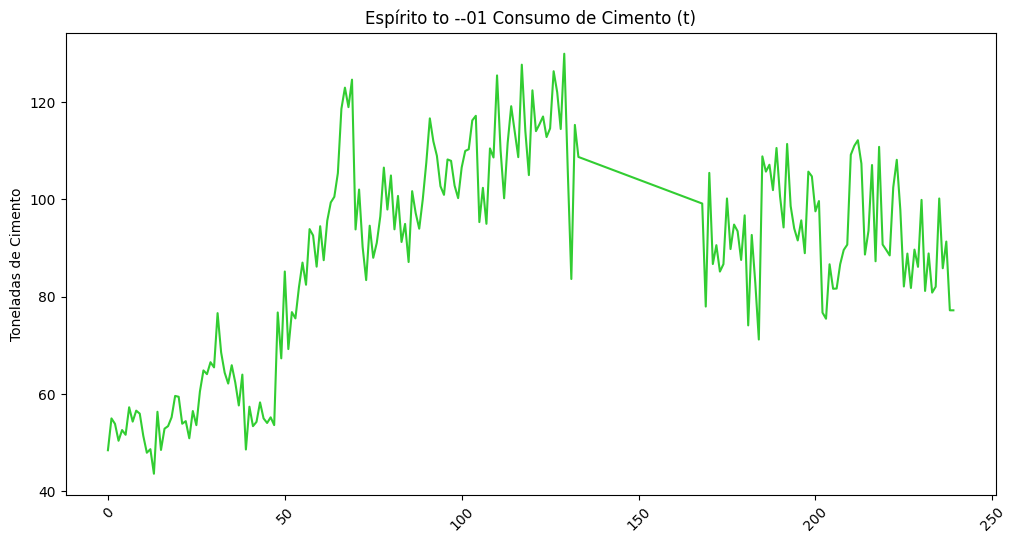

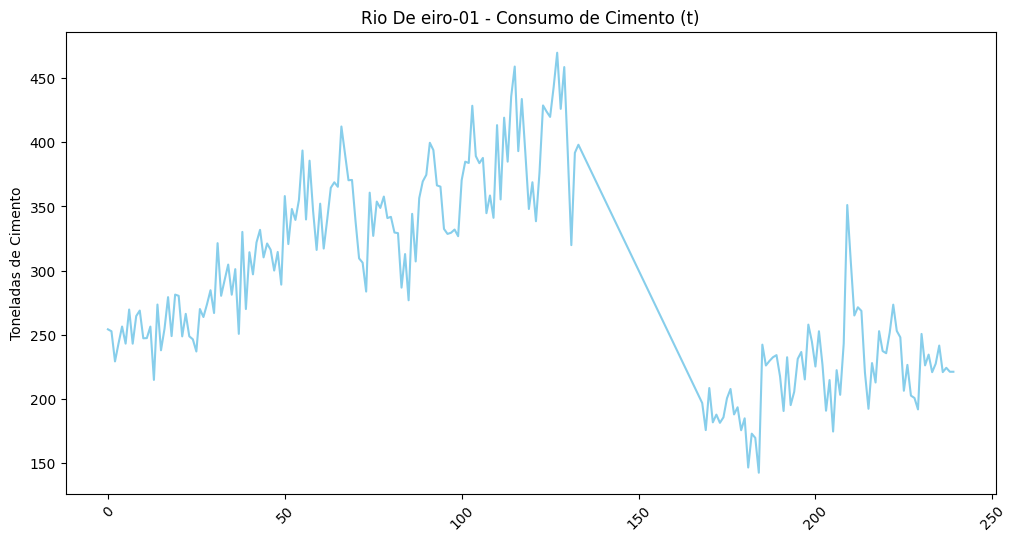

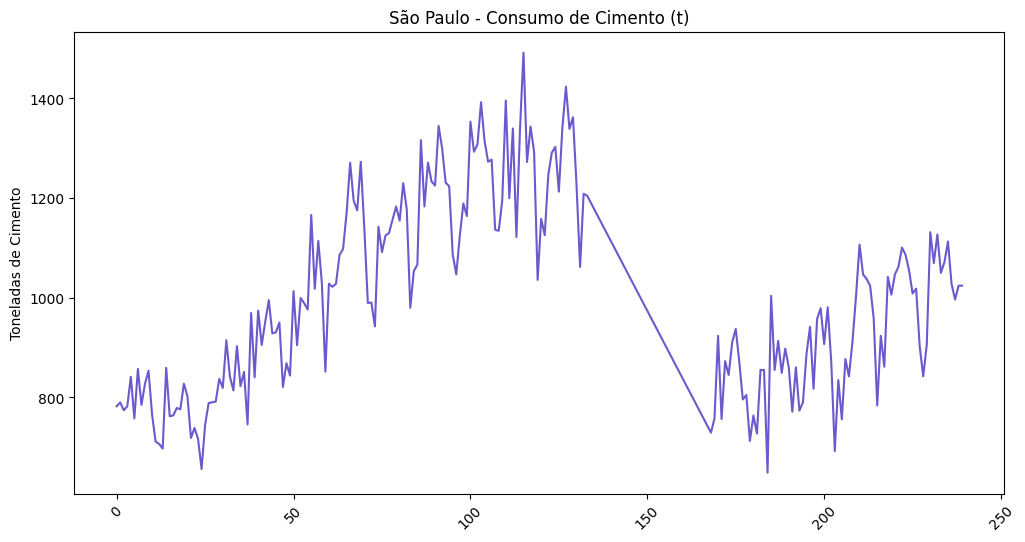

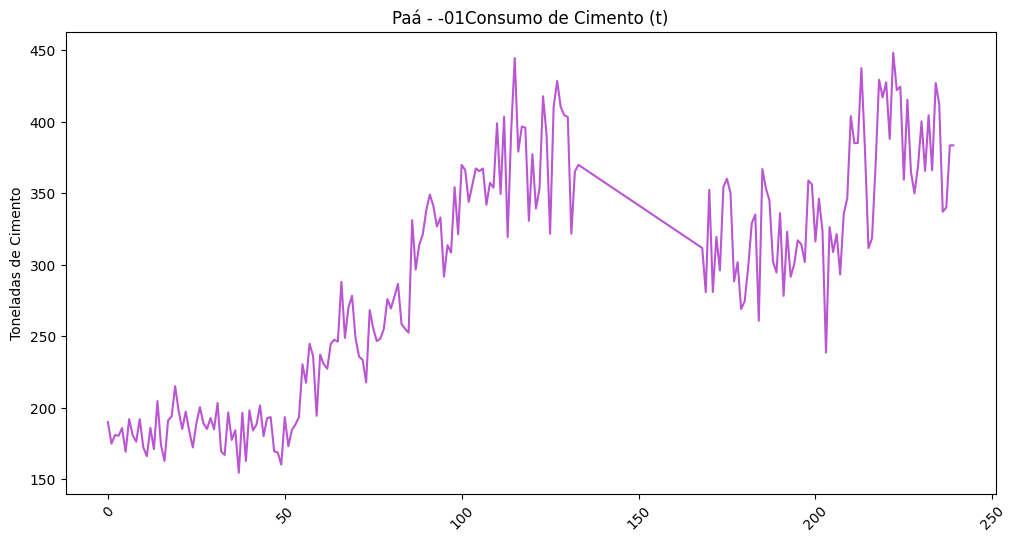

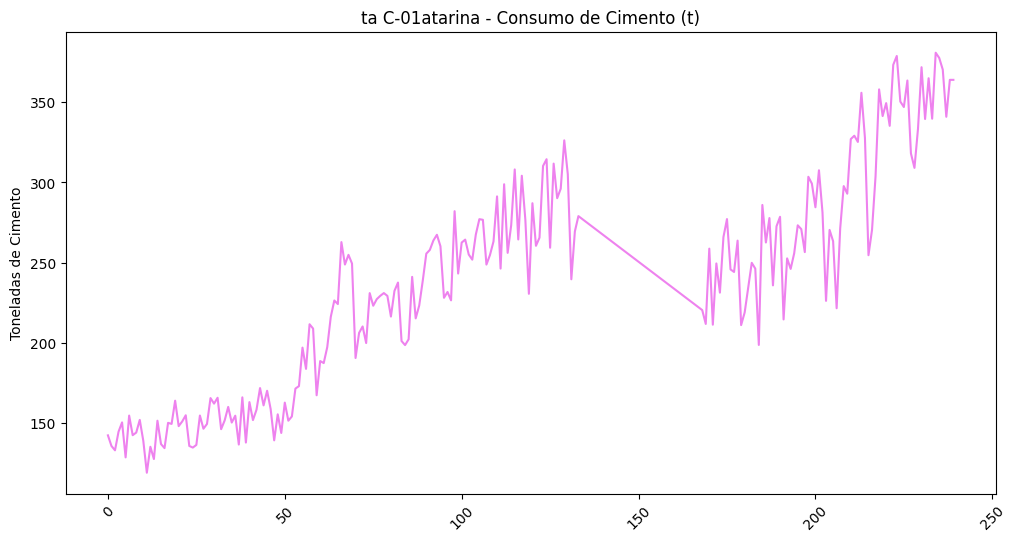

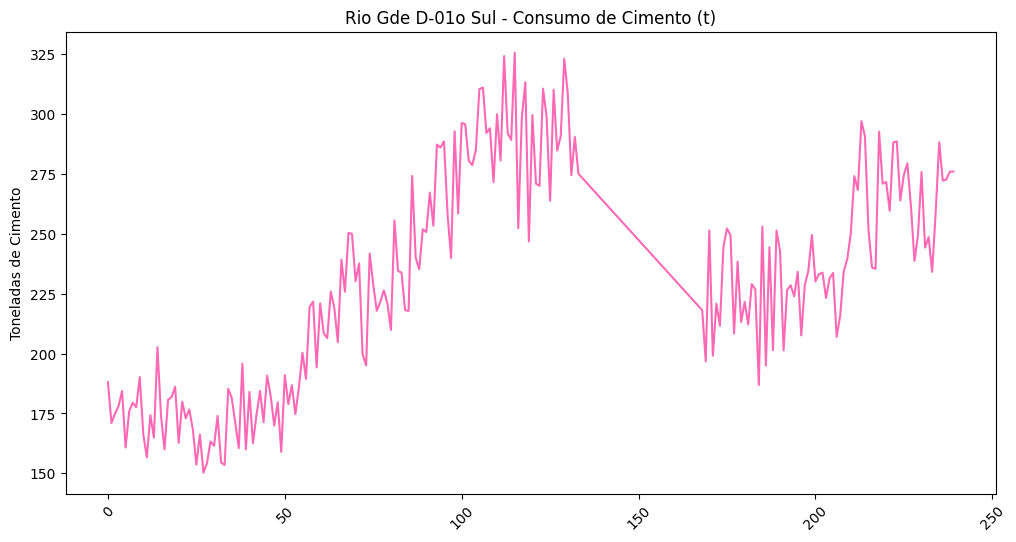

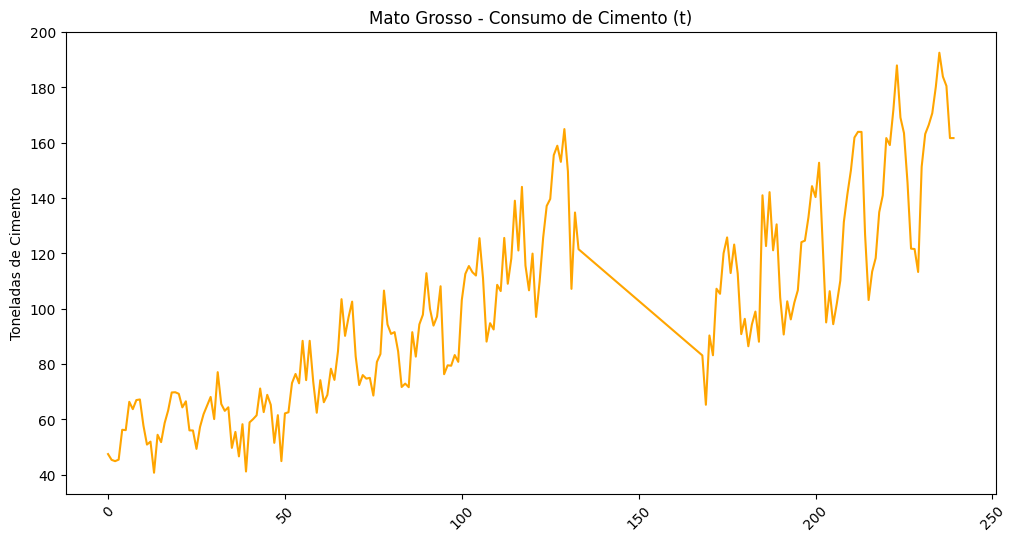

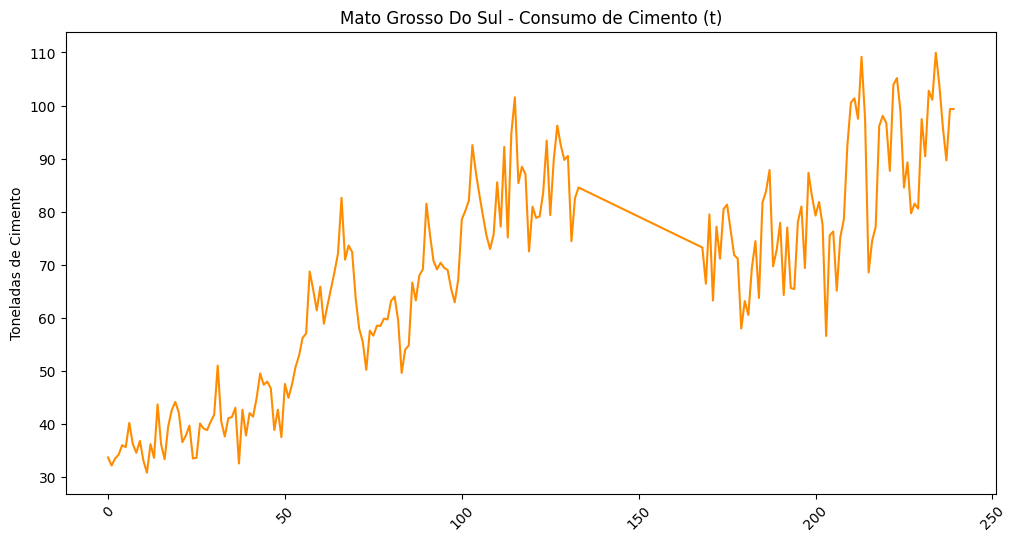

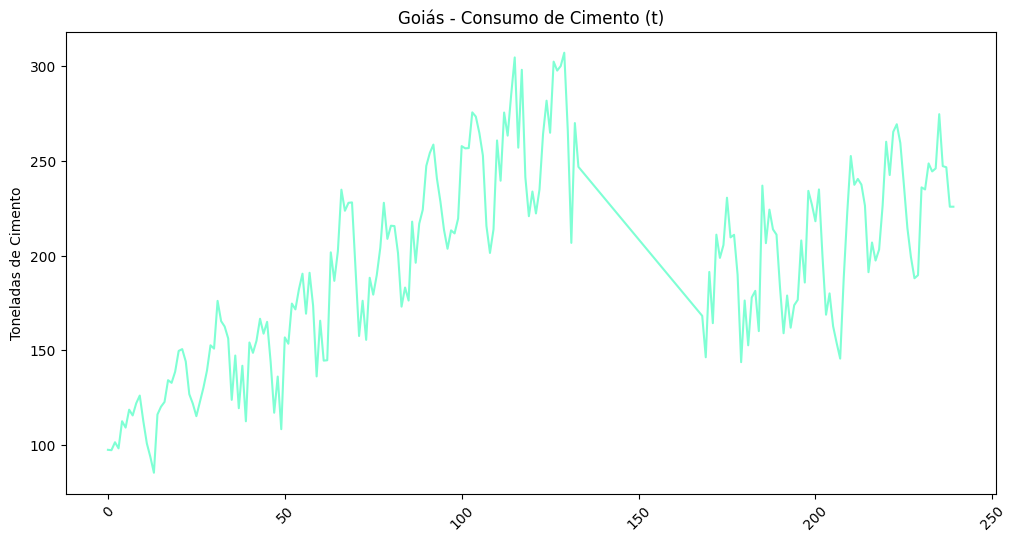

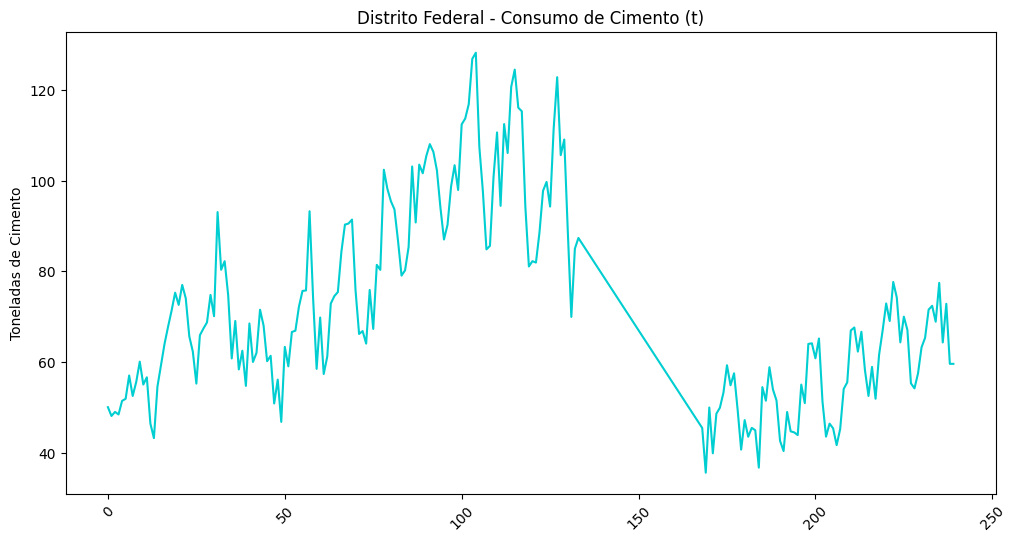

In [10]:
colors = ['#FF0000', '#FF7F00', '#FFFF00', '#00FF00', '#0000FF', '#4B0082', '#8B00FF', '#9400D3', '#FF00FF',
          '#00FFFF', '#008000', '#800000', '#808000', '#008080', '#800080', '#FF4500', '#FFD700', '#ADFF2F',
          '#32CD32', '#87CEEB', '#6A5ACD', '#BA55D3', '#EE82EE', '#FF69B4', '#FFA500', '#FF8C00', '#7FFFD4',
          '#00CED1']

for i, column in enumerate(df.columns):
    if i > 1:
        plot_column(df[column], color=colors[i])

In [11]:
df_cma = df.copy()
for column in df.columns:
    if column != 'Ano': 
        df_cma[column] = centered_moving_average(df_cma[column], (0, len(df_cma) - 1), 12)
df_cma

Ano  Rondônia - Consumo de Cimento (t)  \
0    2003-01                          15.292769   
1    2003-02                          15.007714   
2    2003-03                          15.140067   
3    2003-04                          15.207187   
4    2003-05                          15.218882   
..       ...                                ...   
235  2022-08                          42.714588   
236  2022-09                          42.279375   
237  2022-10                          41.584200   
238  2022-11                          41.277929   
239  2022-12                          41.317077   

     Acre - Consumo de Cimento (t)  Amazonas - Consumo de Cimento (t)  \
0                         3.669846                          34.818462   
1                         3.686143                          35.804500   
2                         3.721000                          35.721200   
3                         3.675562                          37.101438   
4                         3.678176                          37.215235   
..                             ...                                ...   
235                      16.963706                          53.146647   
236                      16.835750                          53.161500   
237                      16.789600                          53.576467   
238                      16.447286                          52.491143   
239                      16.533231                          52.727231   

     Roraima - Consumo de Cimento (t)  Pará - Consumo de Cimento (t)  \
0                            6.156615                      89.424154   
1                            6.074429                      88.490571   
2                            6.034133                      87.735933   
3                            5.751563                      87.297438   
4                            5.631235                      86.991000   
..                                ...                            ...   
235                         11.357765                     134.363588   
236                         11.316187                     134.149187   
237                         11.442133                     133.609133   
238                         11.229000                     132.367286   
239                         11.018000                     132.152308   

     Amapá - Consumo de Cimento (t)  Totins-01 - Consumo de Cimento (t)  \
0                          7.314846                           19.892923   
1                          7.230643                           20.112929   
2                          7.090067                           20.780467   
3                          6.892313                           21.325250   
4                          6.851412                           21.807765   
..                              ...                                 ...   
235                       12.527647                           46.248176   
236                       12.420687                           45.841375   
237                       12.466200                           45.563067   
238                       12.333429                           45.324786   
239                       12.105154                           45.554000   

     Mahão -01- Consumo de Cimento (t)  Piauí - Consumo de Cimento (t)  ...  \
0                            39.446308                       19.792231  ...   
1                            38.784643                       19.564571  ...   
2                            38.912400                       19.732533  ...   
3                            38.966813                       19.902062  ...   
4                            38.963059                       20.103294  ...   
..                                 ...                             ...  ...   
235                          92.088118                       68.684588  ...   
236                          91.673687                       68.262687  ...   
237                          91.473600    

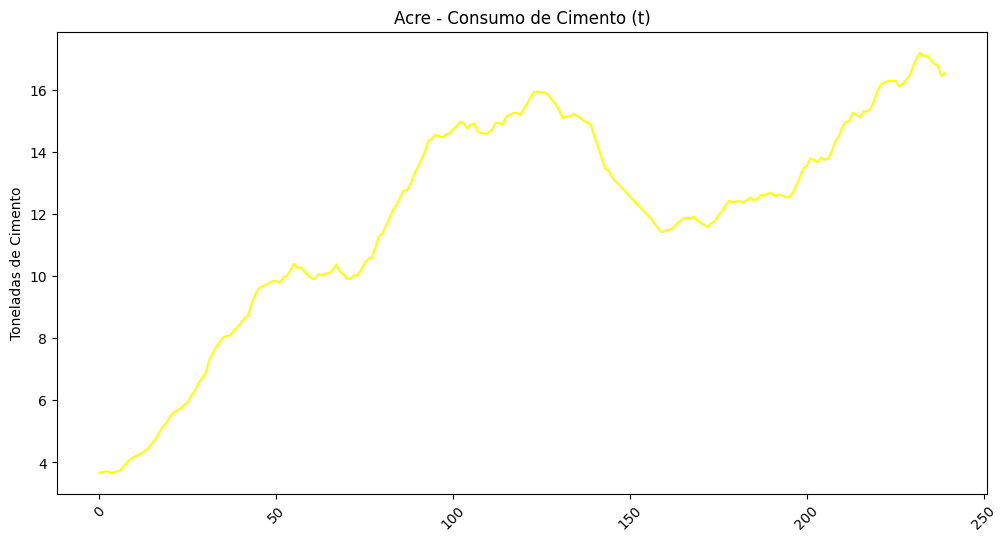

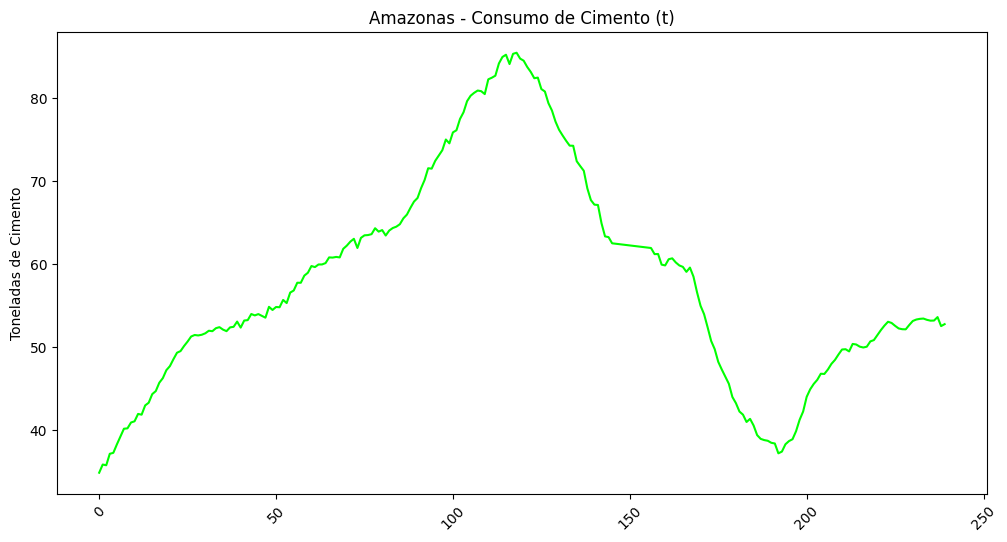

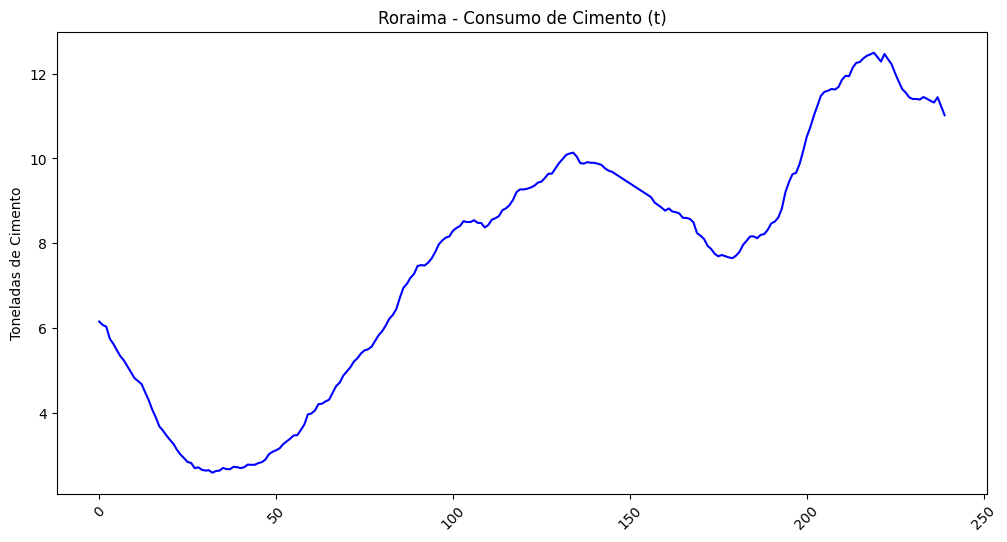

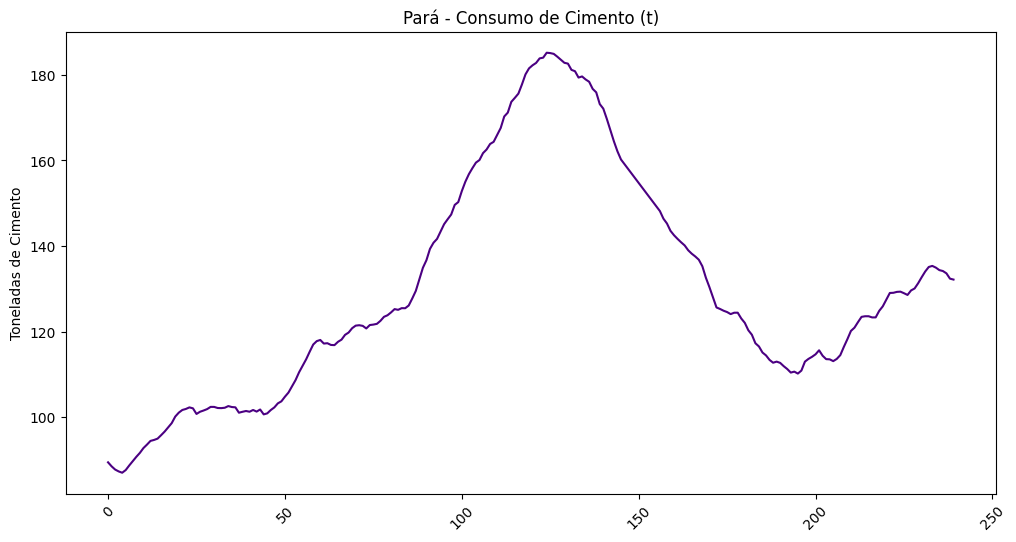

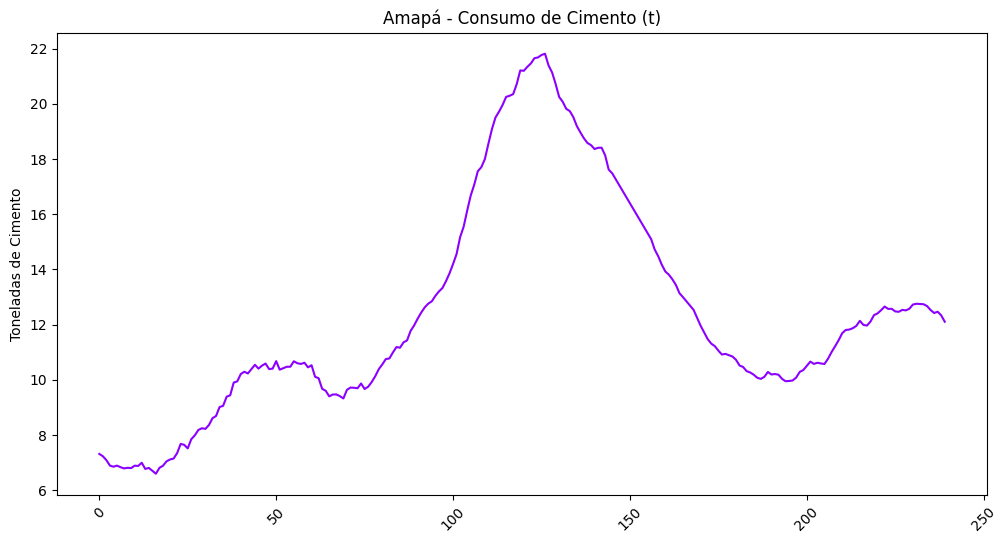

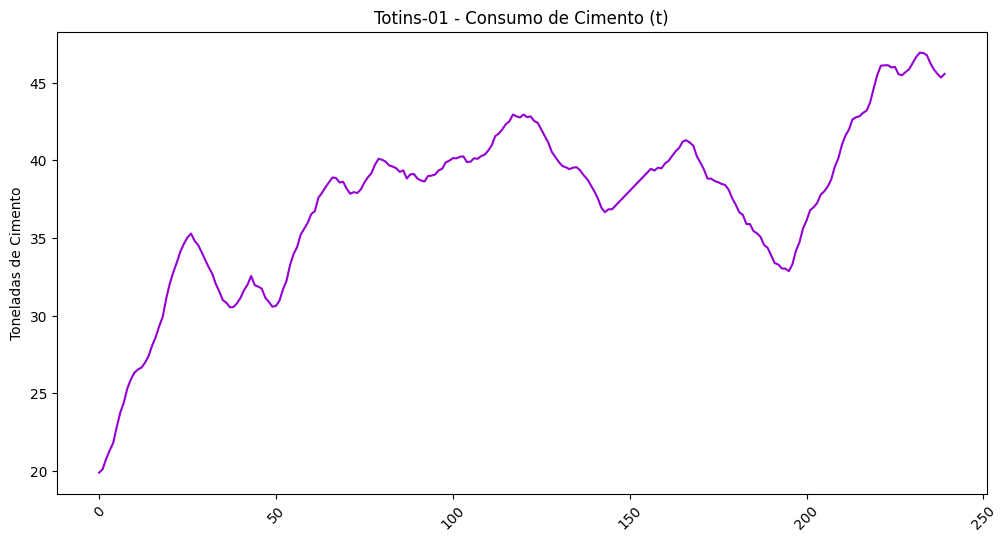

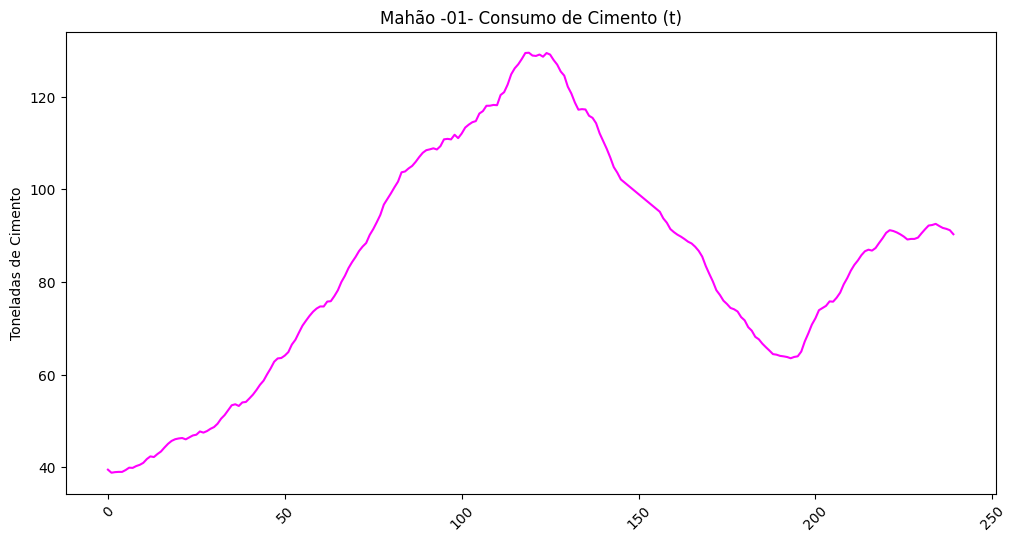

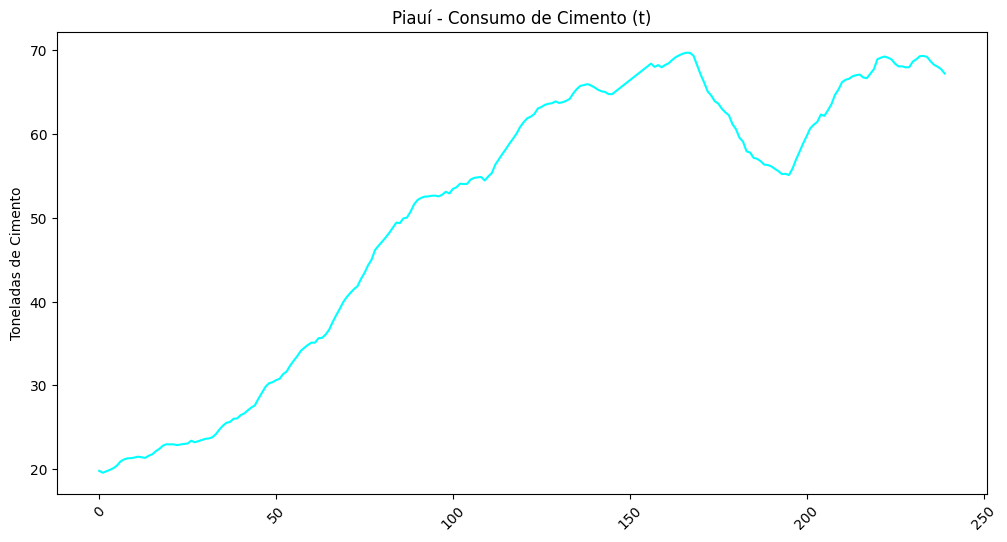

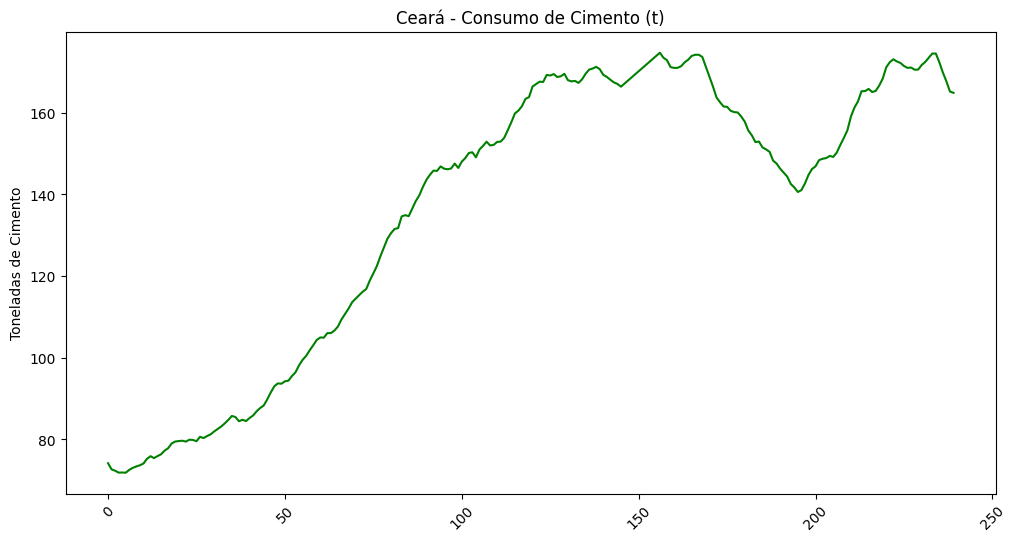

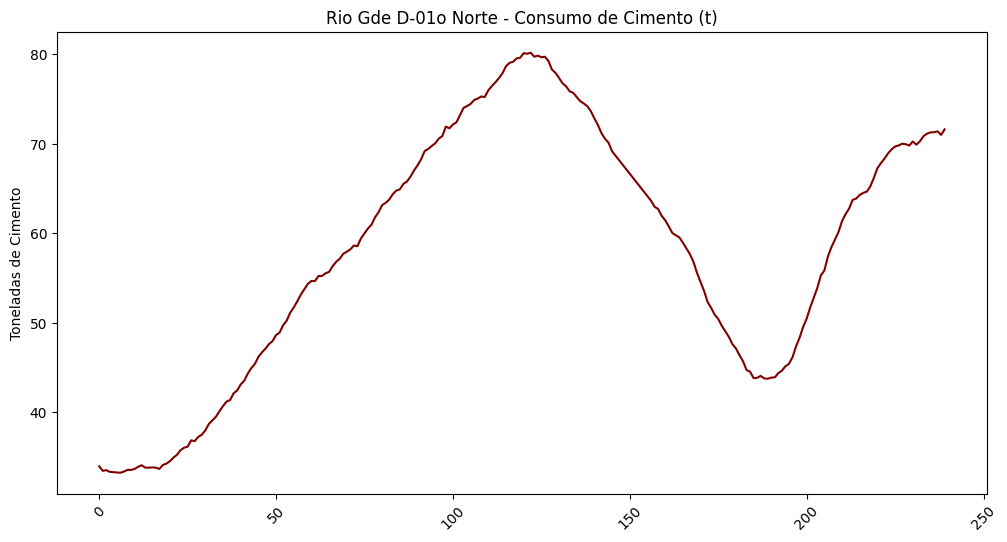

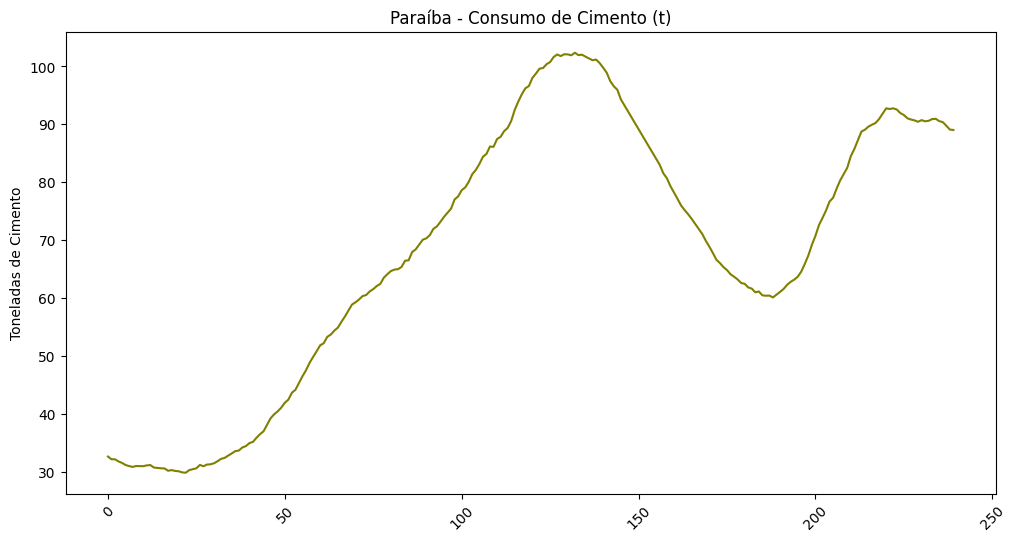

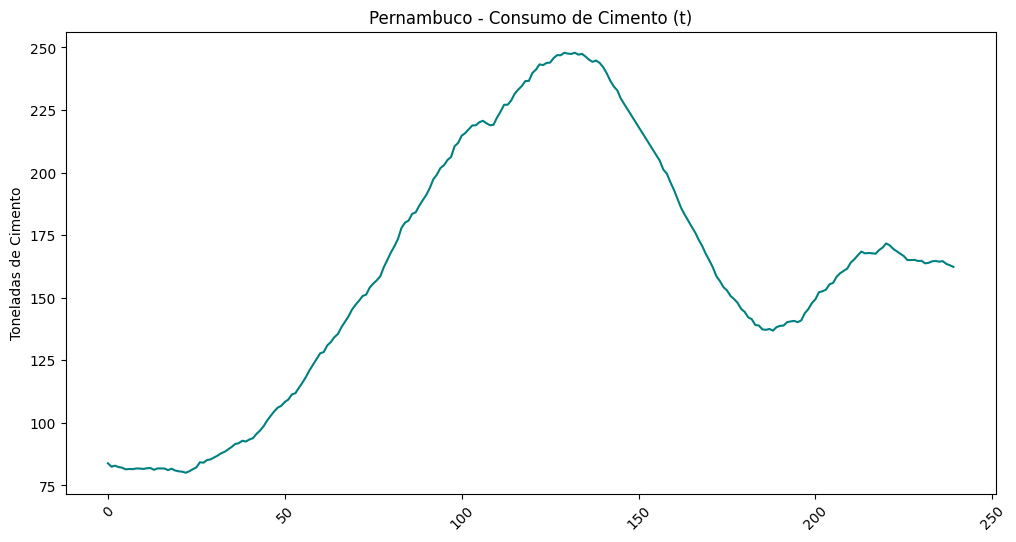

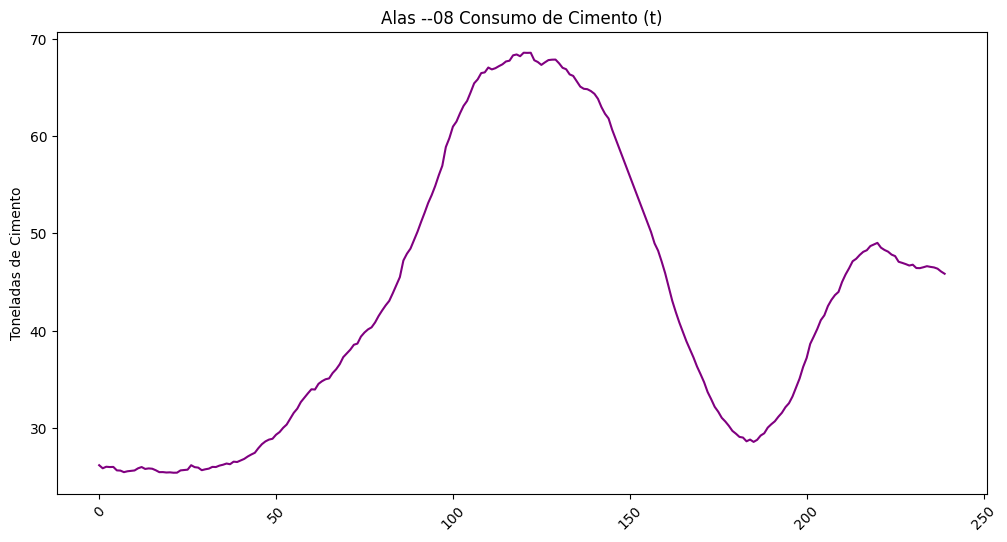

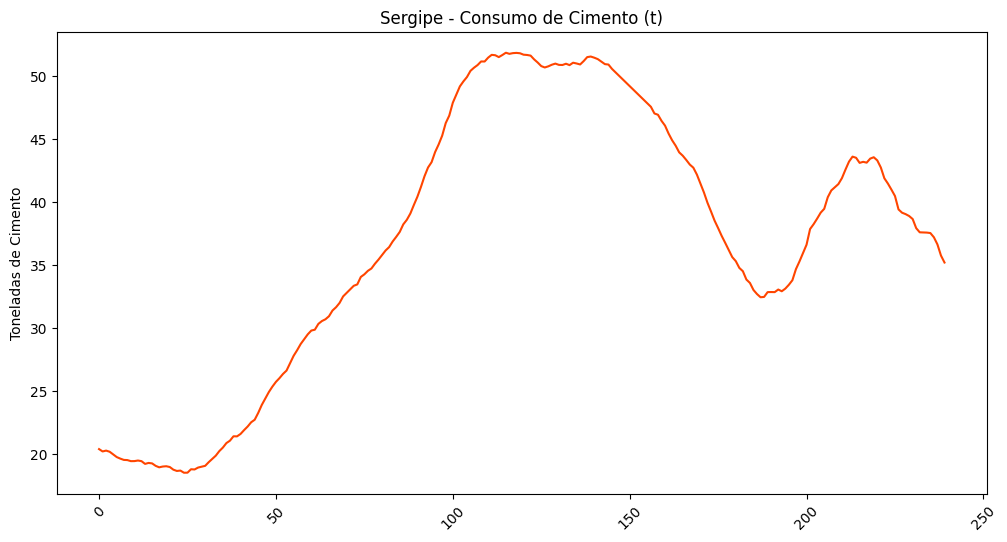

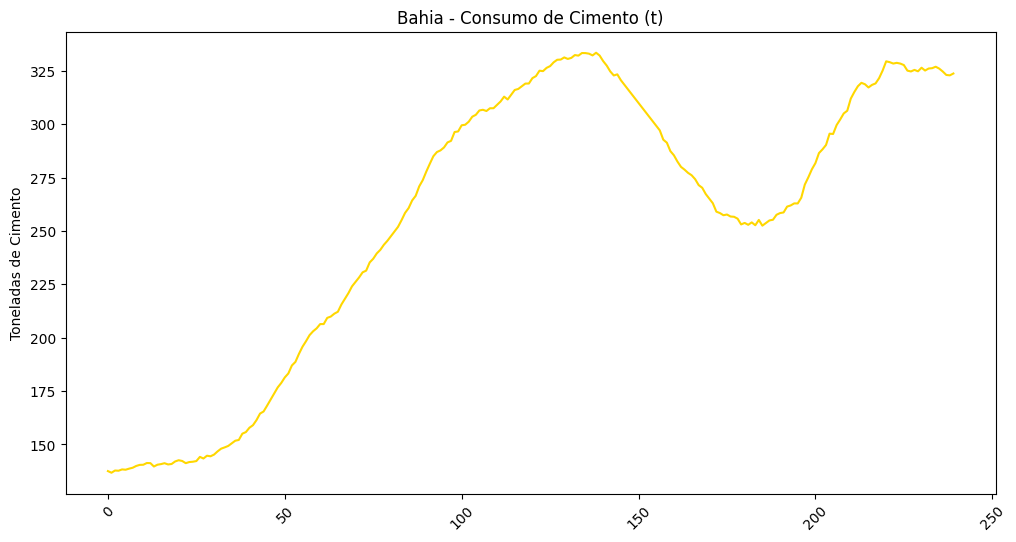

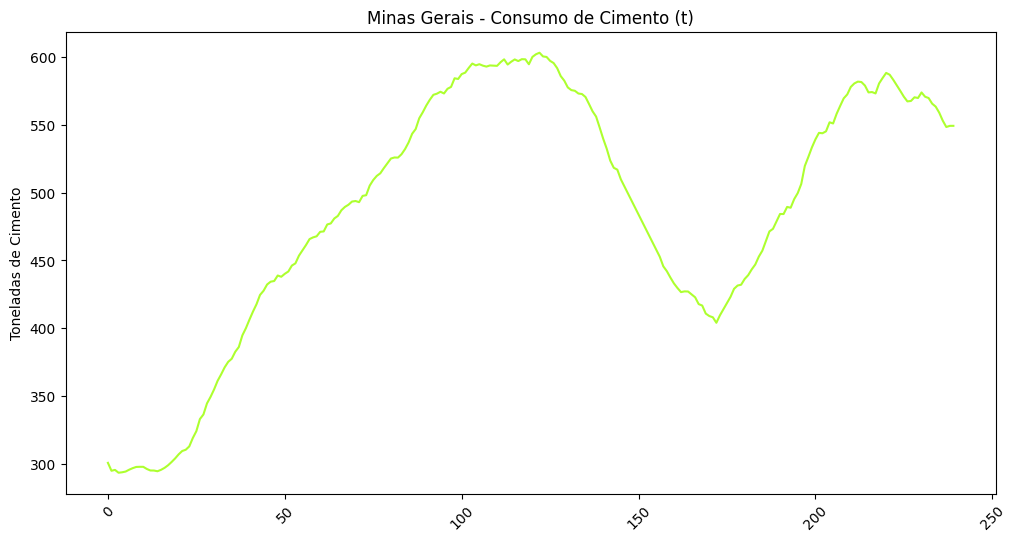

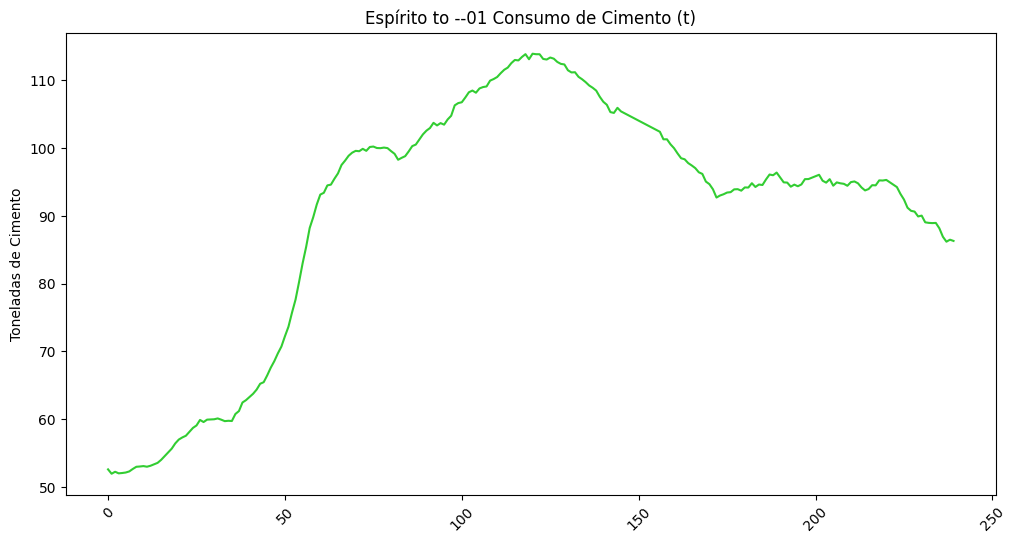

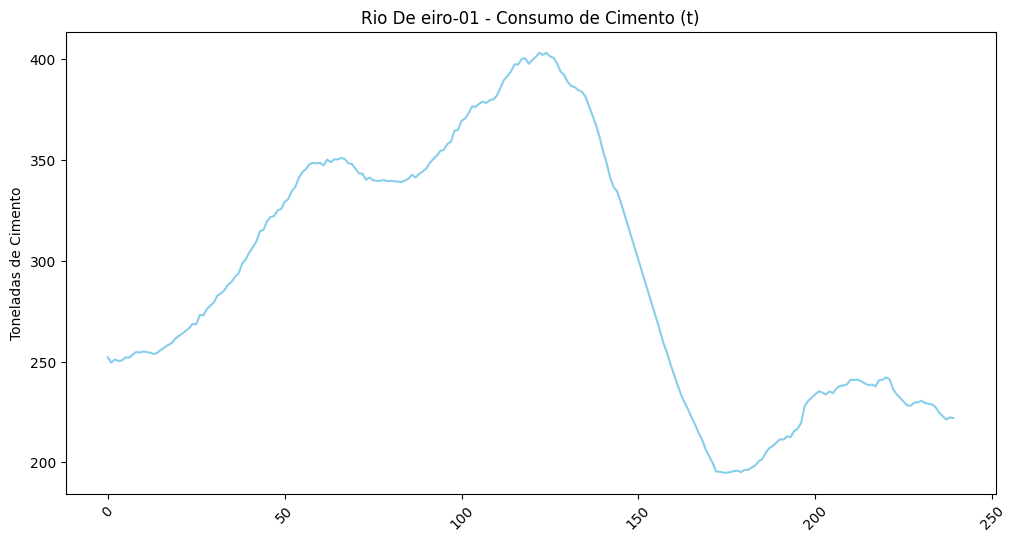

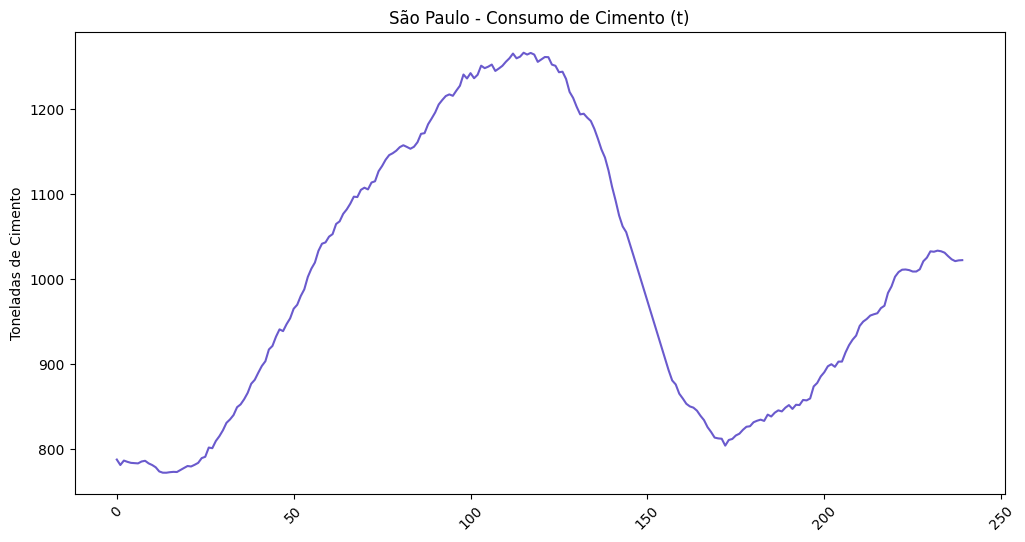

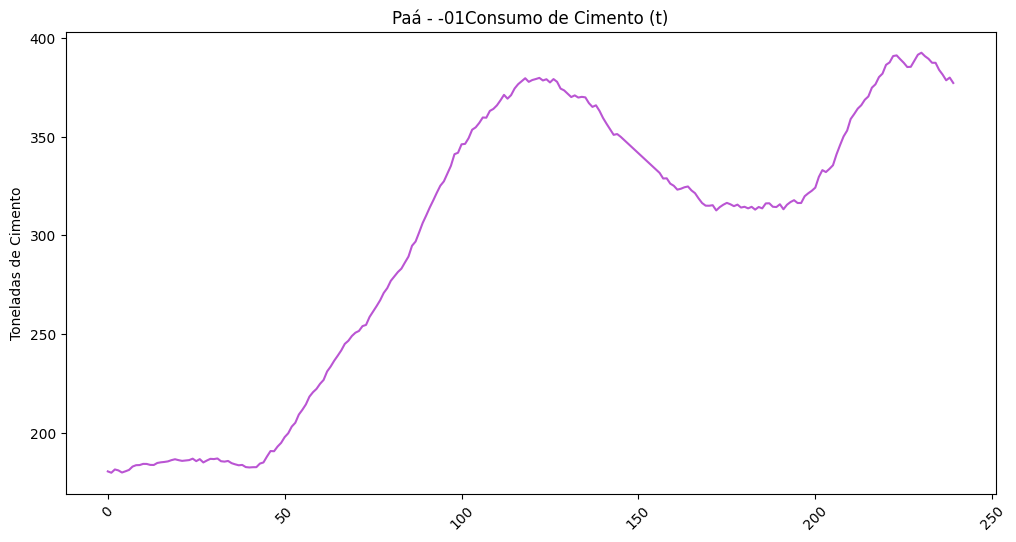

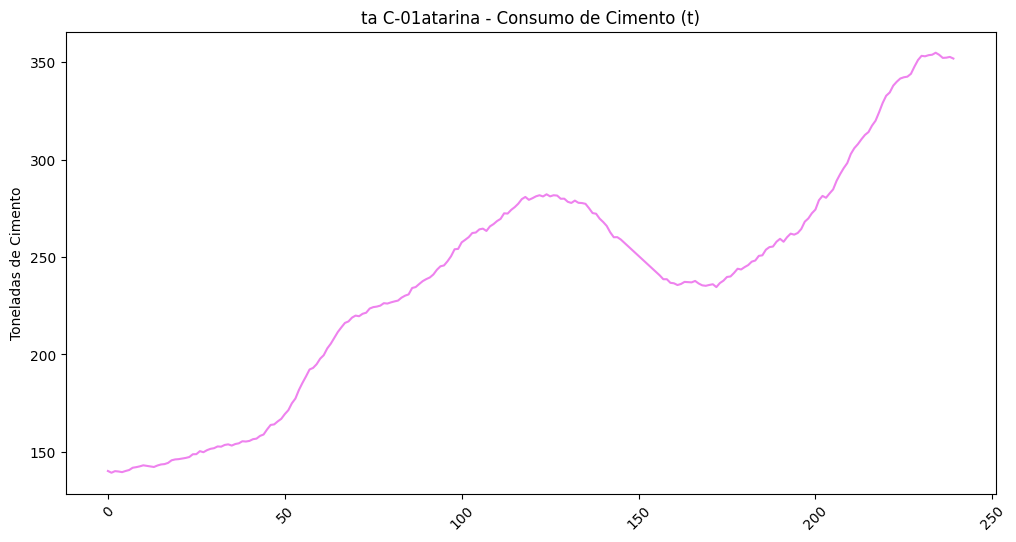

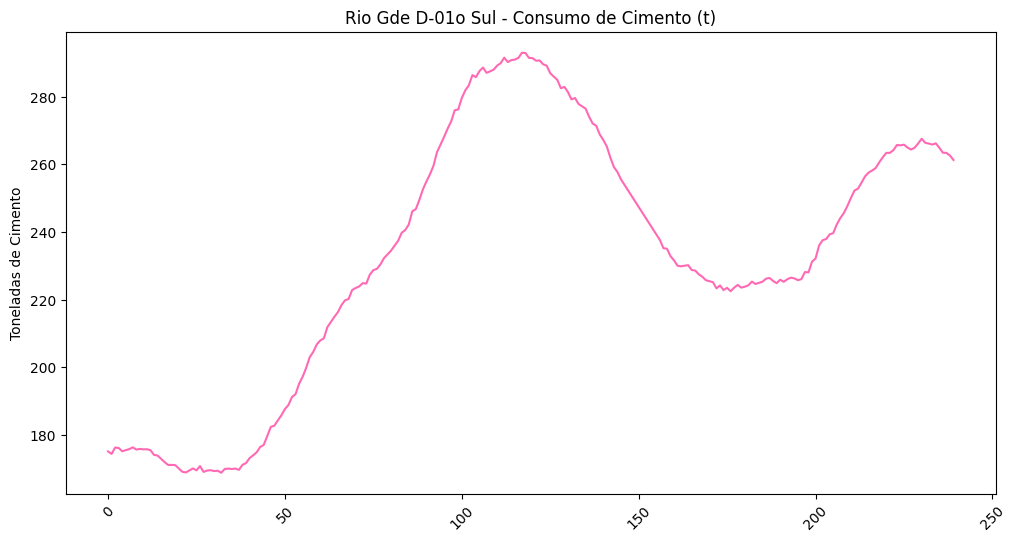

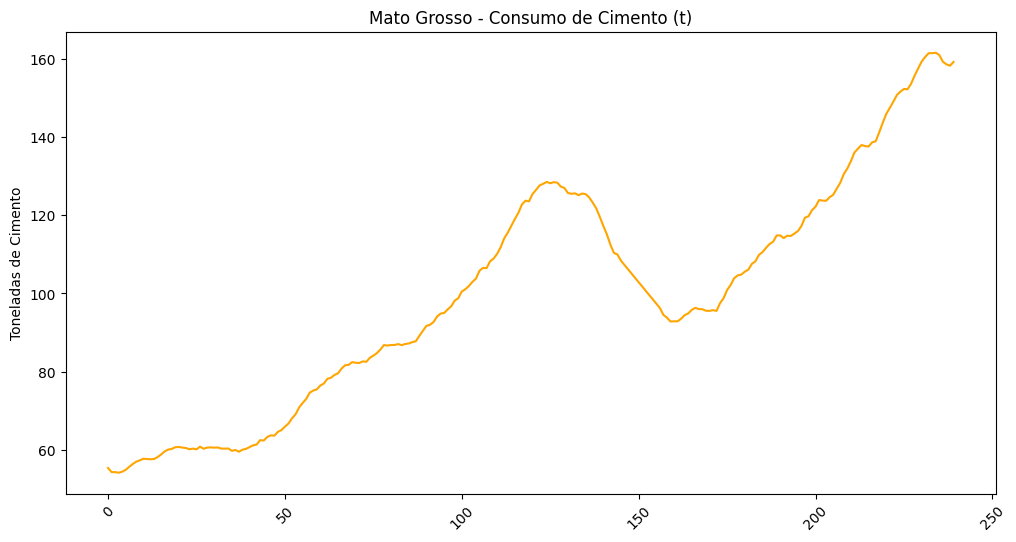

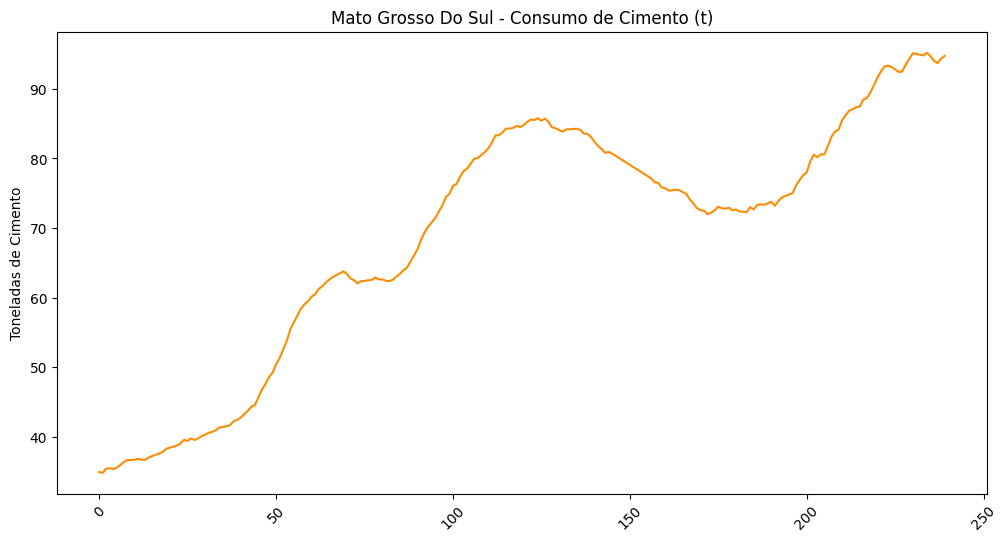

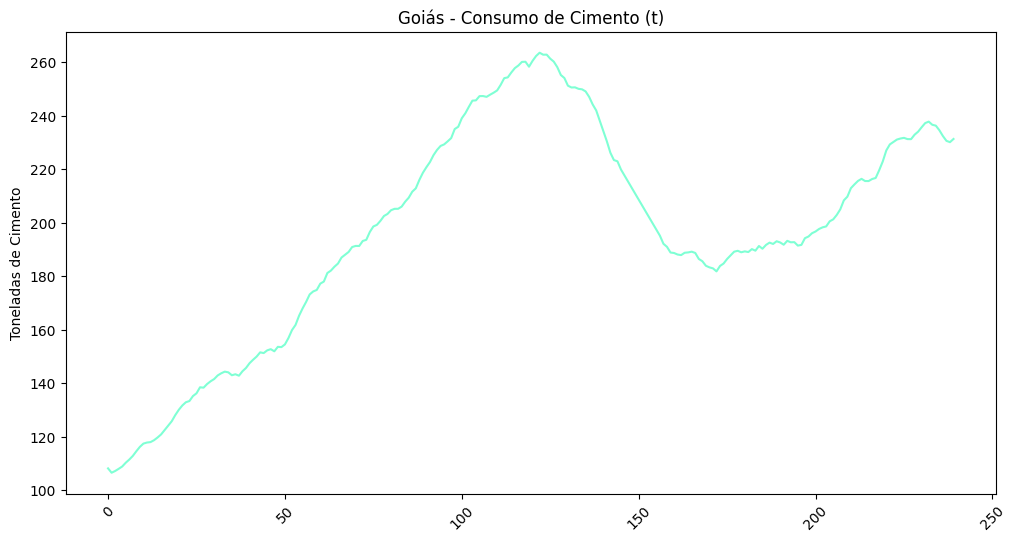

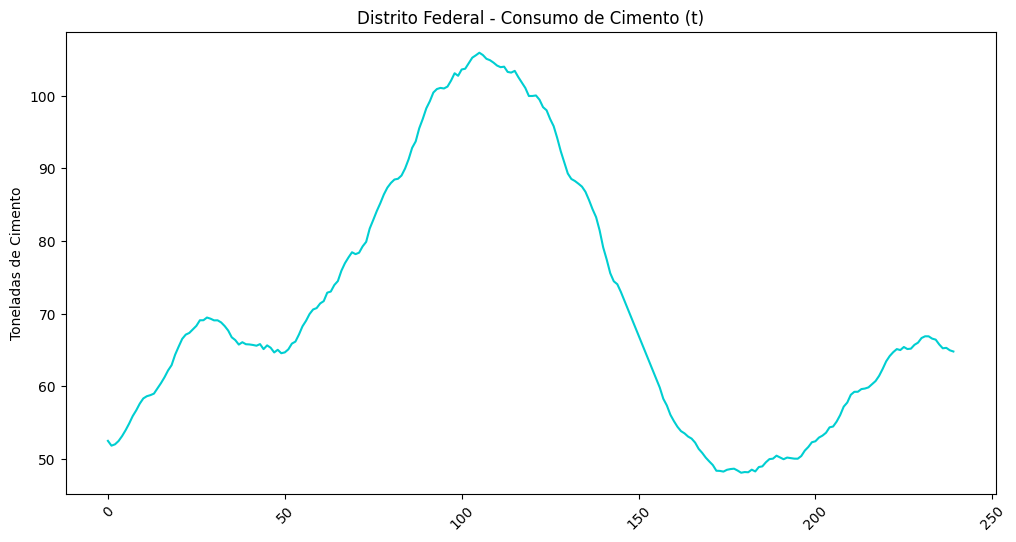

In [12]:
for i, column in enumerate(df_cma.columns):
    if i > 1:
        plot_column(df_cma[column], color=colors[i])

In [13]:
df_year = df_cma.copy()
df_year['Ano'] = df_year['Ano'].str[:4]
df_year = df_year.groupby('Ano').sum()
df_year

Rondônia - Consumo de Cimento (t)  Acre - Consumo de Cimento (t)  \
Ano                                                                      
2003                         187.983449                      46.369317   
2004                         210.719240                      60.500360   
2005                         232.856000                      82.803360   
2006                         277.499360                     106.099680   
2007                         344.031400                     120.543840   
2008                         389.105120                     120.756040   
2009                         536.608160                     131.004040   
2010                         835.079840                     161.209280   
2011                         991.833520                     176.814320   
2012                         935.272560                     179.331920   
2013                         811.153674                     187.904486   
2014                         644.728561                     176.468247   
2015                         510.450879                     151.604993   
2016                         429.285230                     139.970658   
2017                         387.062216                     143.264696   
2018                         389.435160                     150.240480   
2019                         418.355640                     157.320440   
2020                         467.214120                     174.487280   
2021                         500.966880                     191.201320   
2022                         507.472580                     201.480263   

      Amazonas - Consumo de Cimento (t)  Roraima - Consumo de Cimento (t)  \
Ano                                                                         
2003                         462.150083                         65.338712   
2004                         550.964480                         44.983360   
2005                         618.299800                         32.550280   
2006                         637.243320                         33.140040   
2007                         675.966440                         40.635640   
2008                         729.046840                         53.827400   
2009                         762.476800                         68.489920   
2010                         817.460800                         87.029080   
2011                         925.231840                         99.945000   
2012                        1002.425480                        105.071440   
2013                         964.570177                        114.559611   
2014                         837.822493                        119.332710   
2015                         747.559107                        113.255450   
2016                         723.335927                        105.333693   
2017                         607.998496                         94.998976   
2018                         482.412280                         97.672320   
2019                         493.849200                        118.872280   
2020                         585.609960                        141.975080   
2021                         620.108120                        146.865480   
2022                         636.235849                        136.392029   

      Pará - Consumo de Cimento (t)  Amapá - Consumo de Cimento (t)  \
Ano                                                                   
2003                    1074.635291                       83.274043   
2004                    1179.635280                       83.892480   
2005                    1223.524600                       99.375600   
2006                    1217.344360                      121.841520   
2007                    1319.248320                      126.120440   
2008                    1424.539920                      116.396960   
2009                    1477.026360                      122.190200   
2010                    1622.775720        

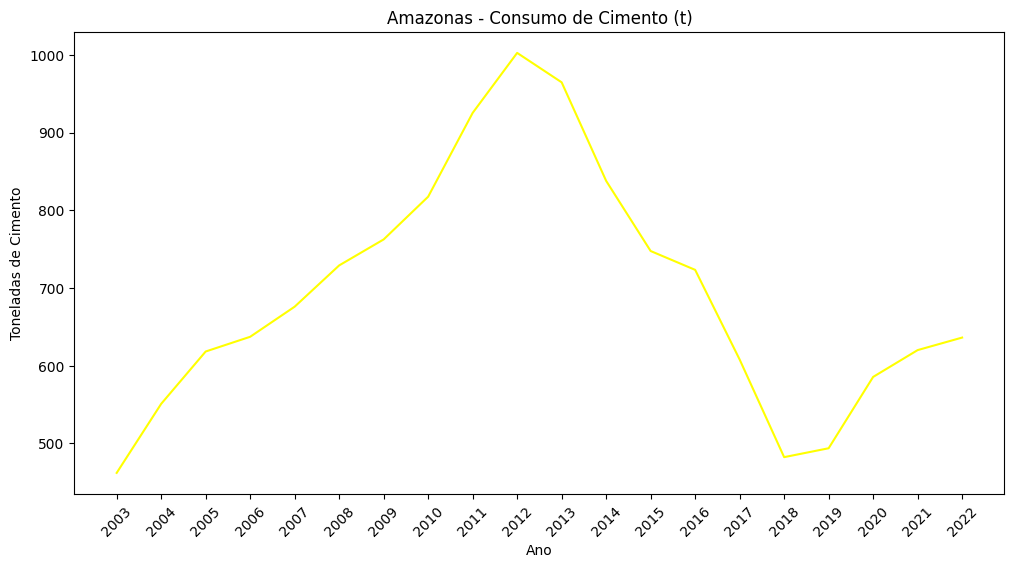

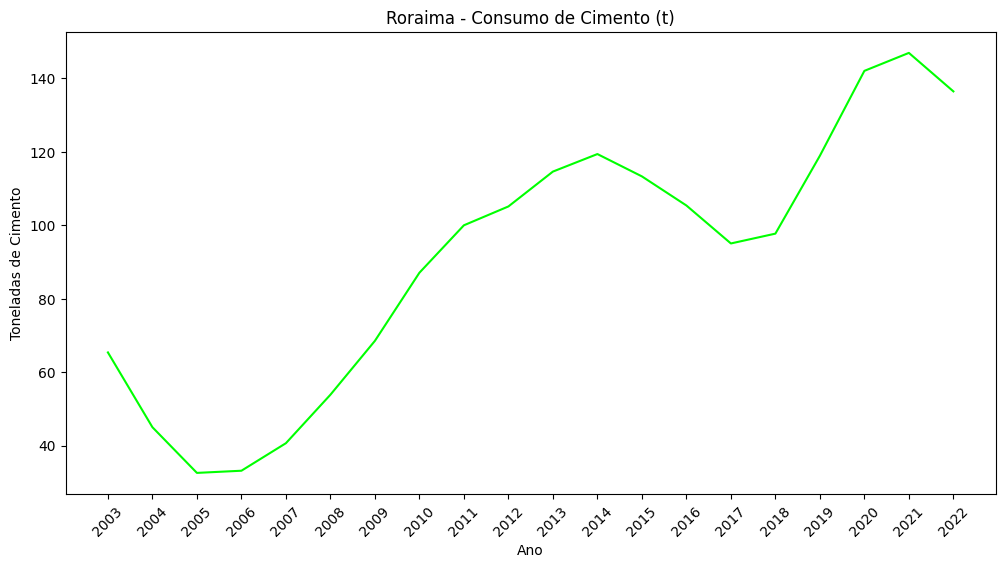

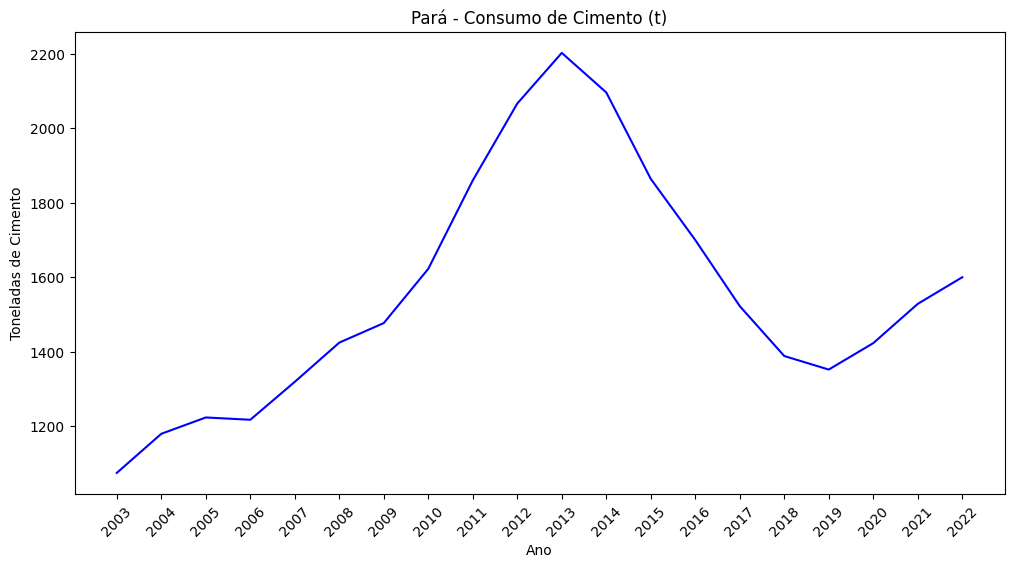

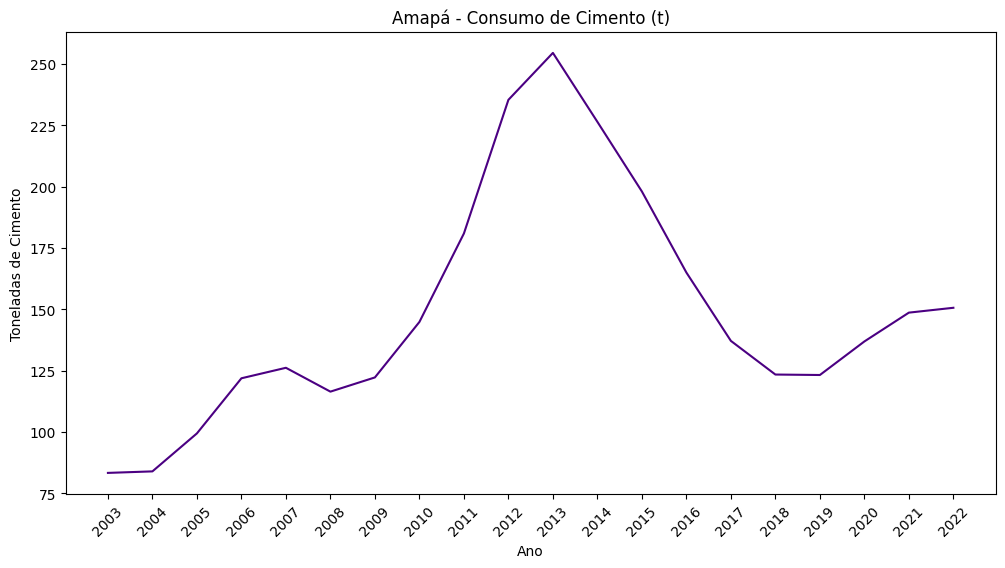

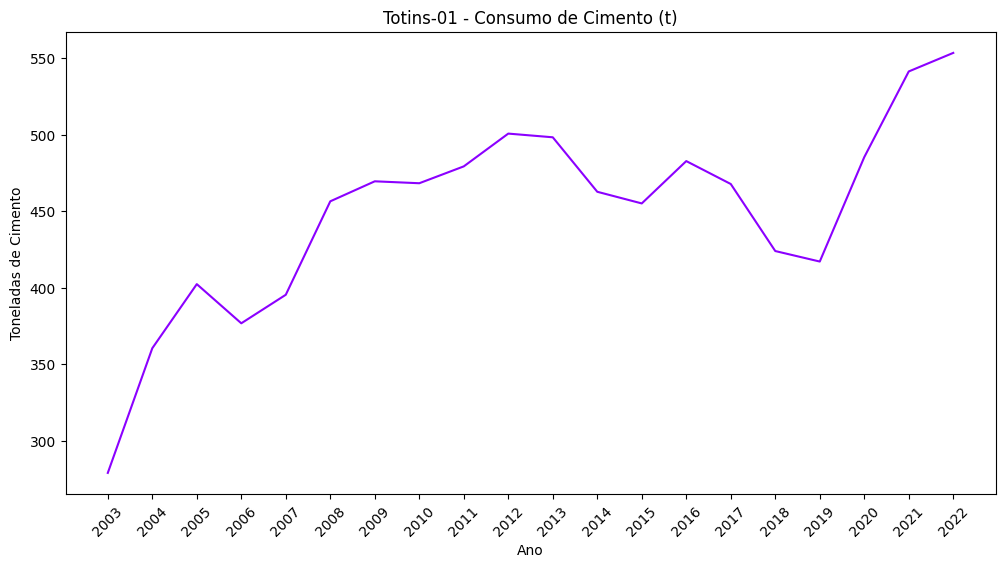

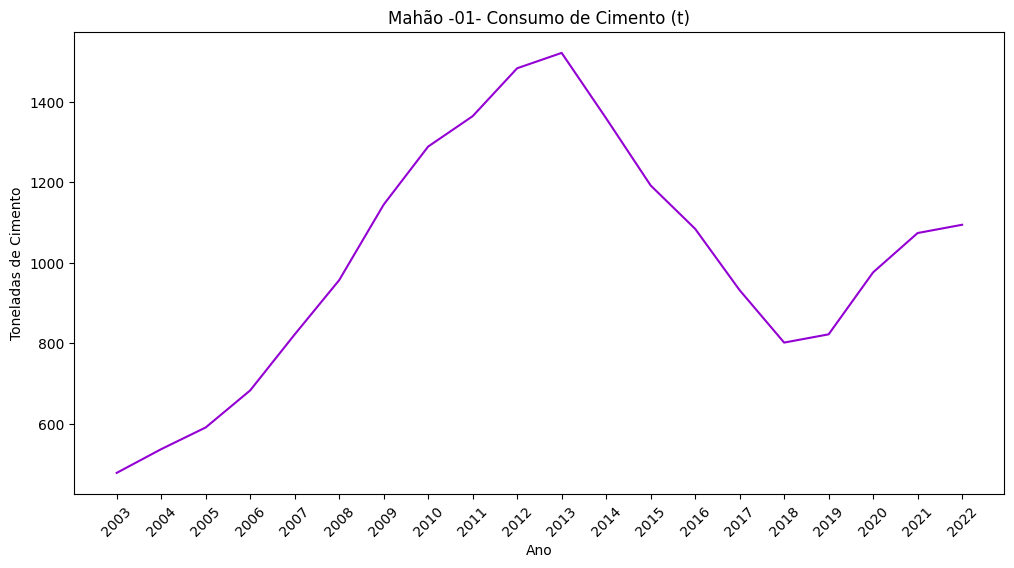

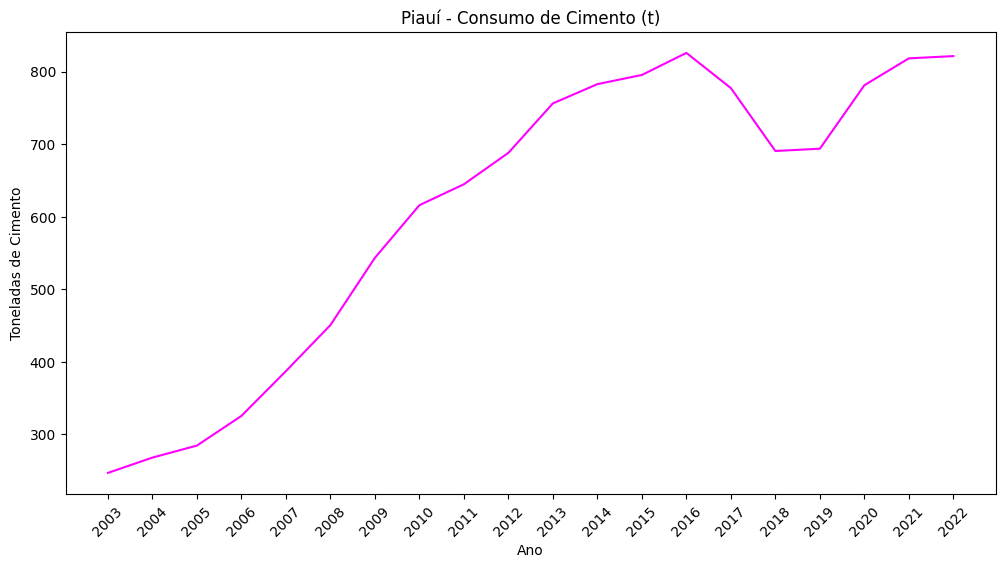

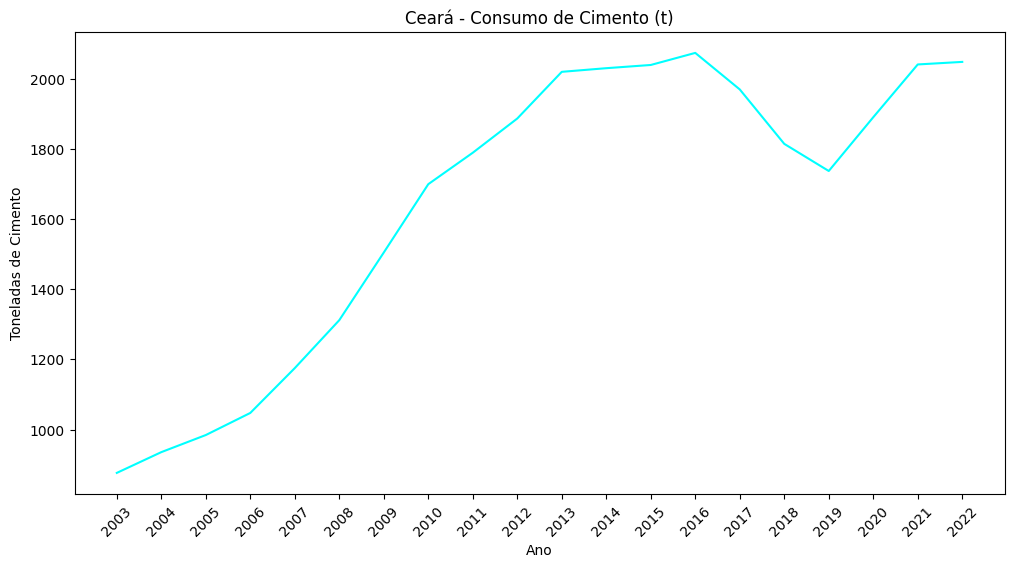

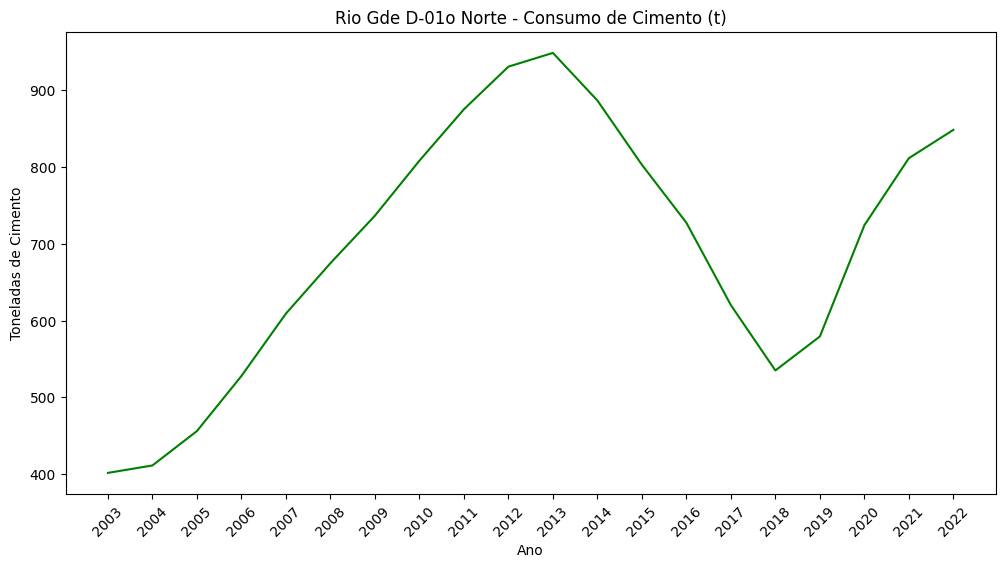

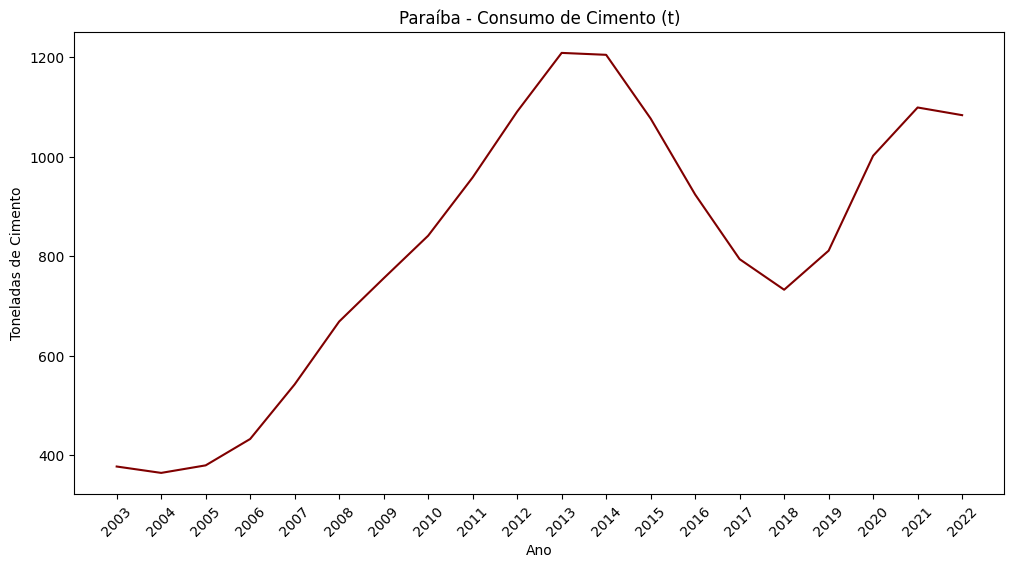

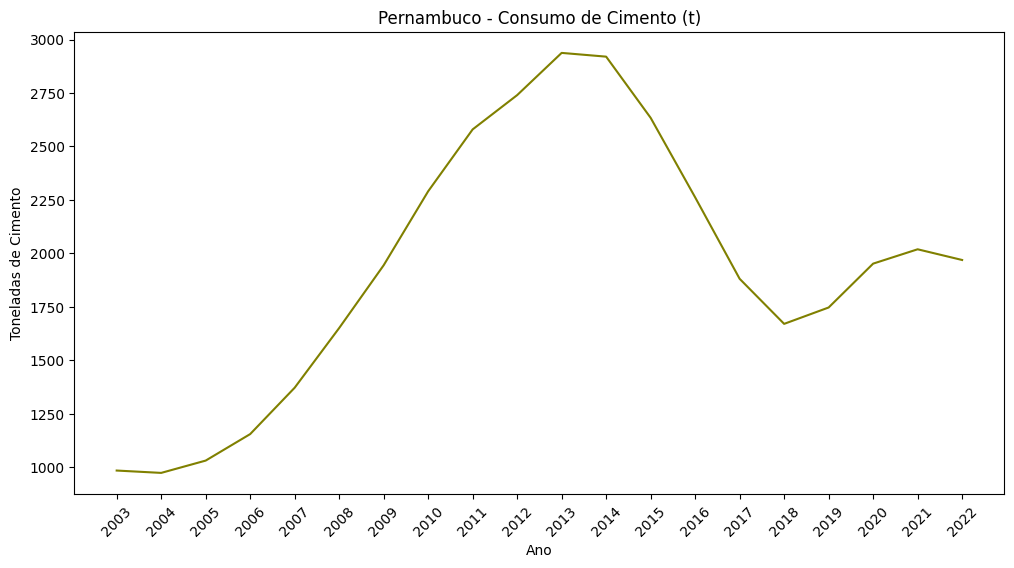

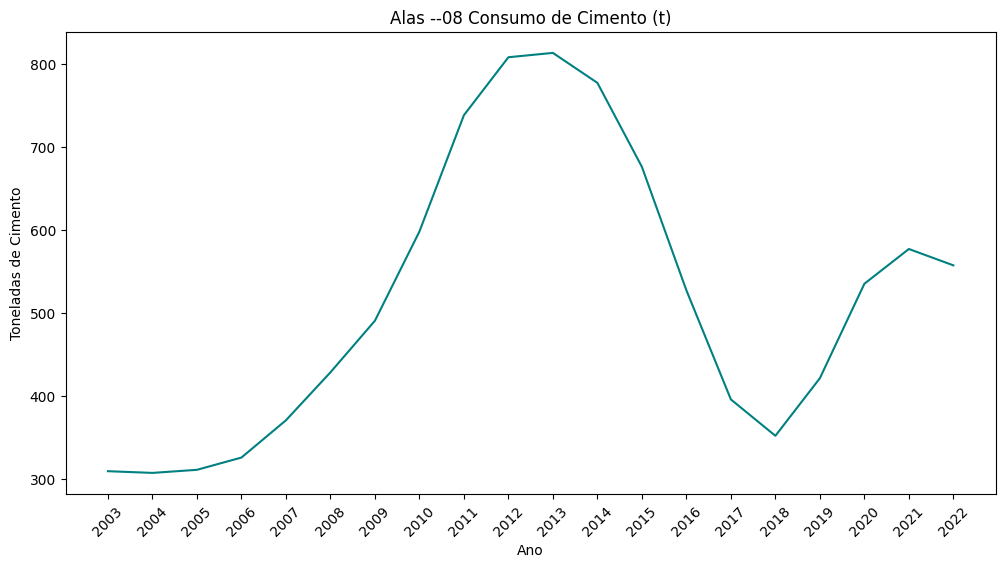

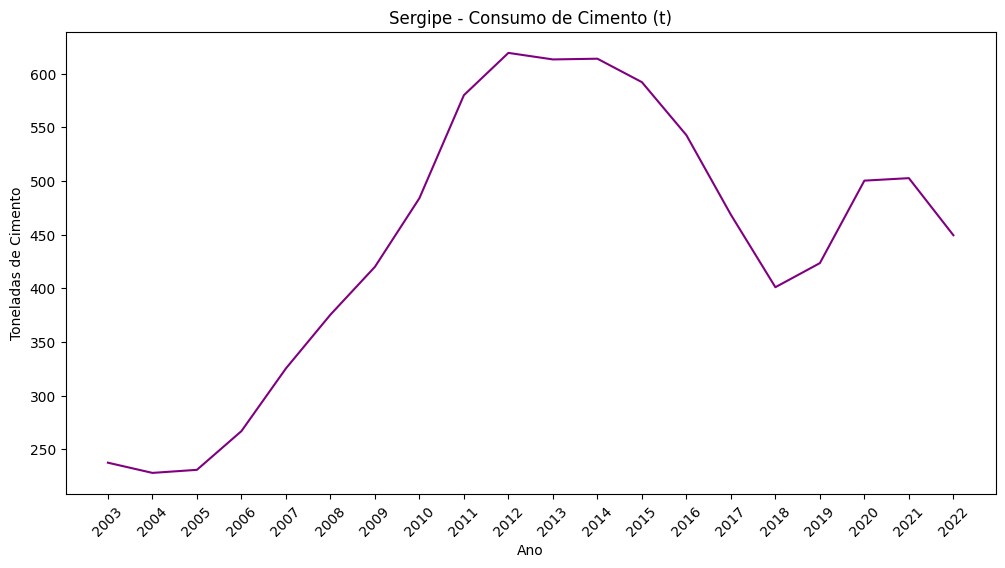

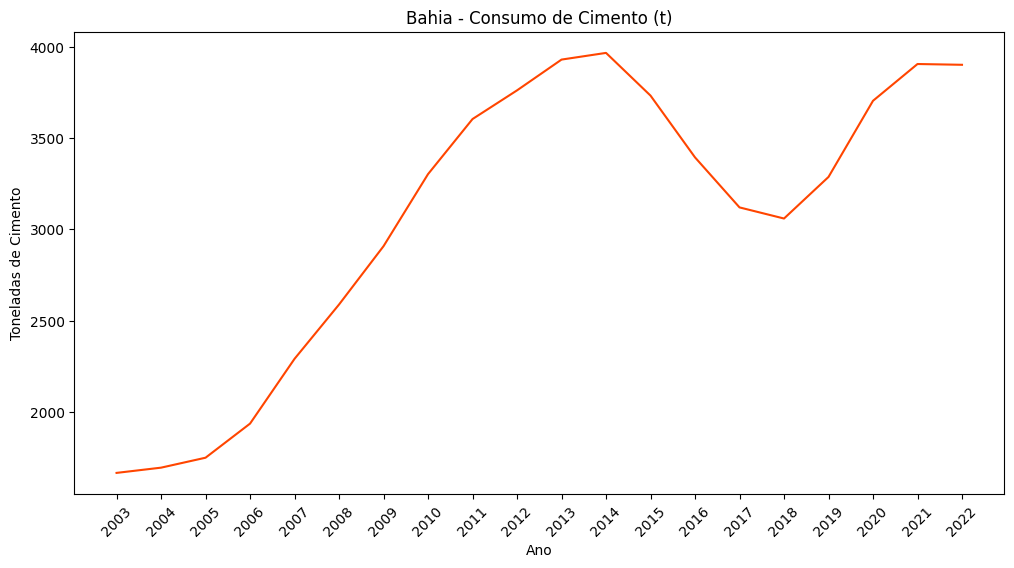

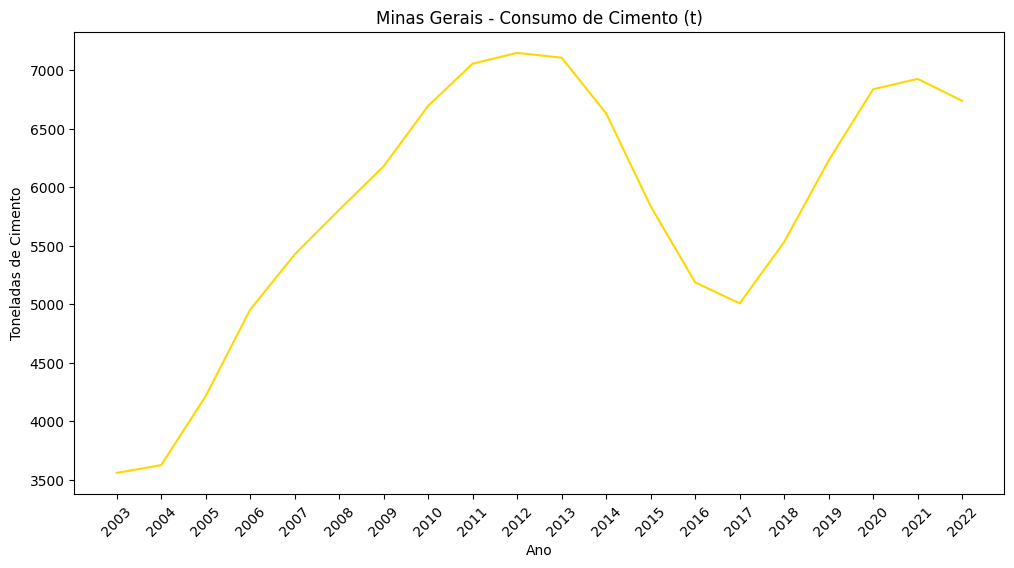

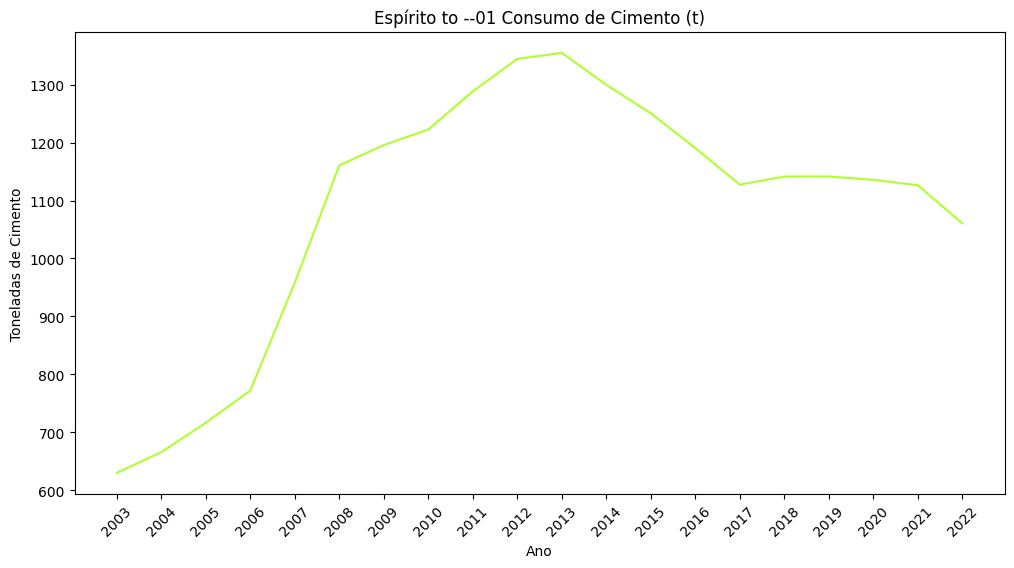

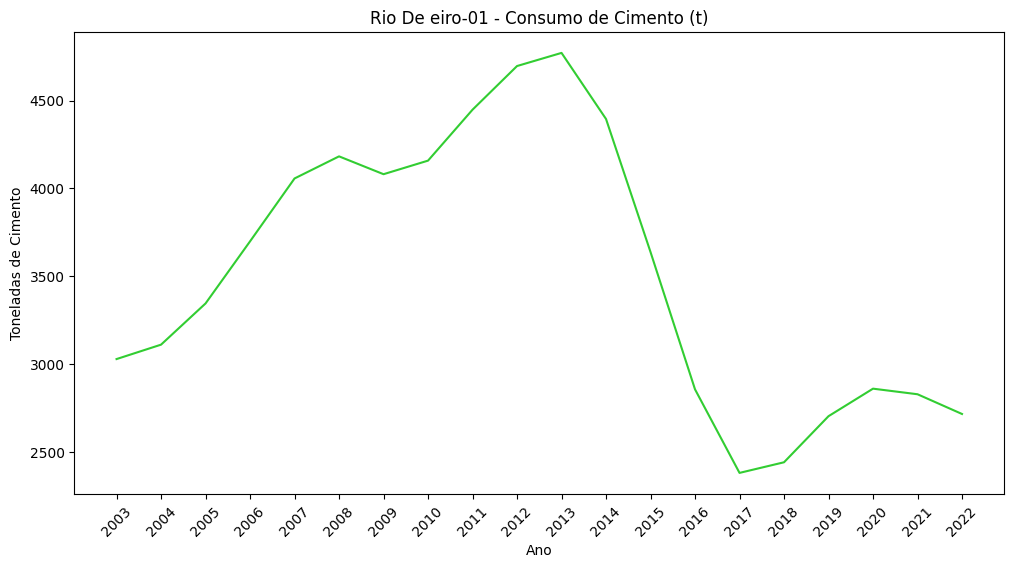

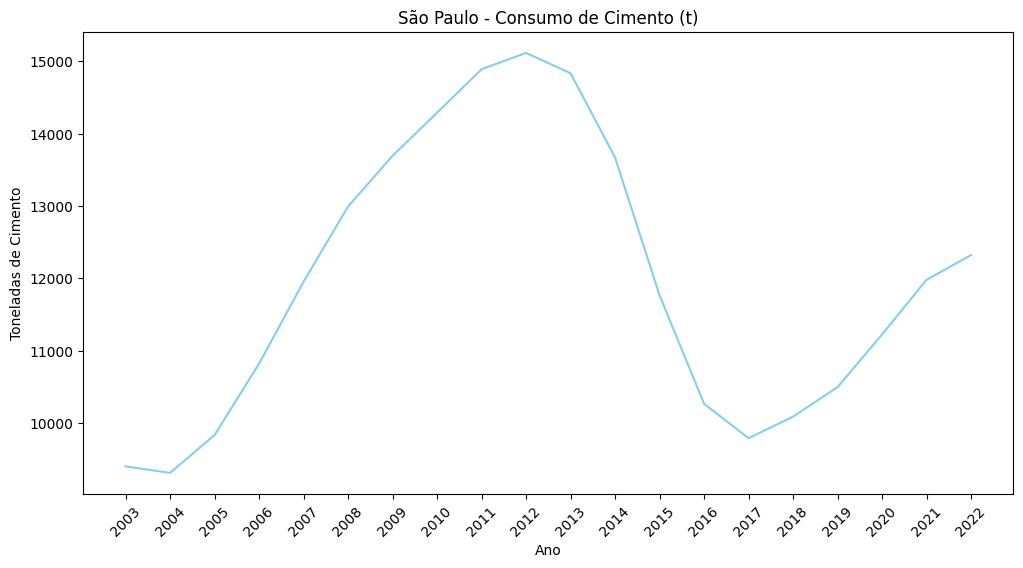

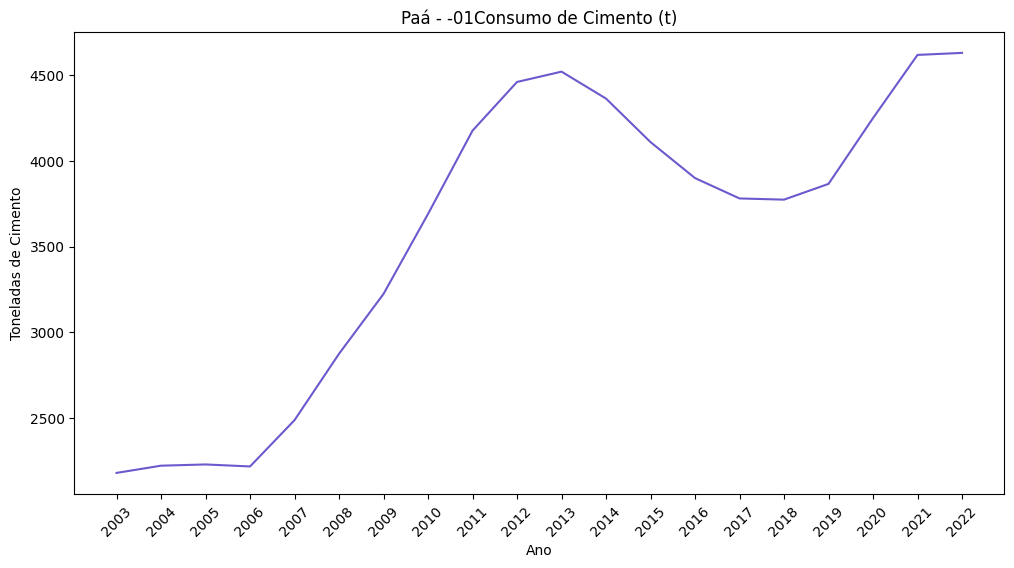

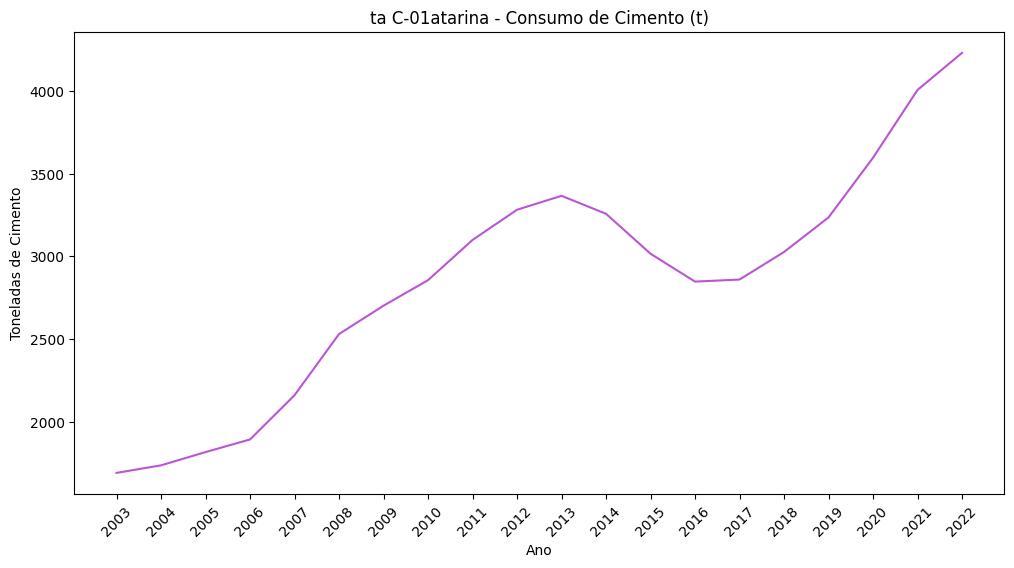

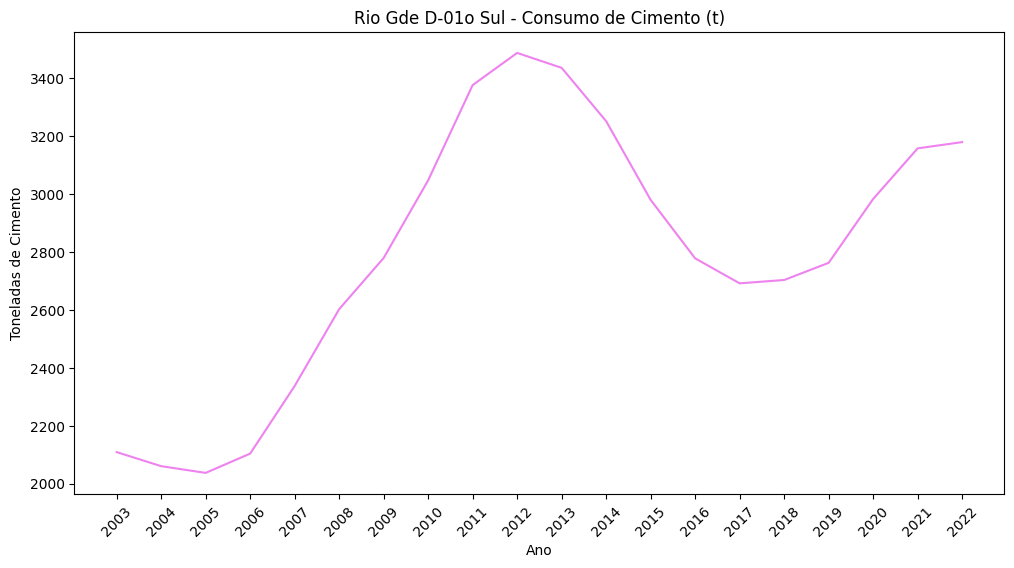

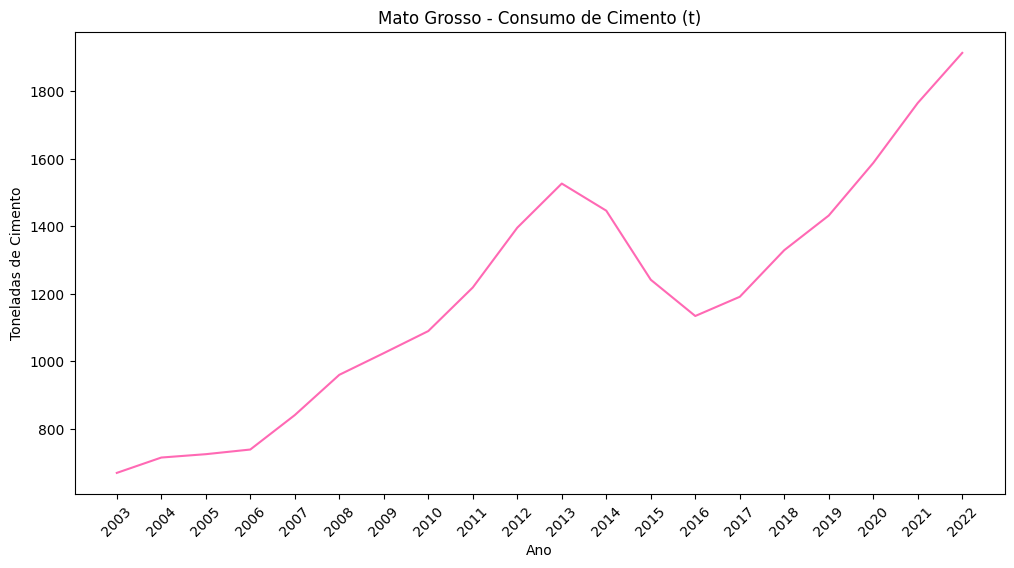

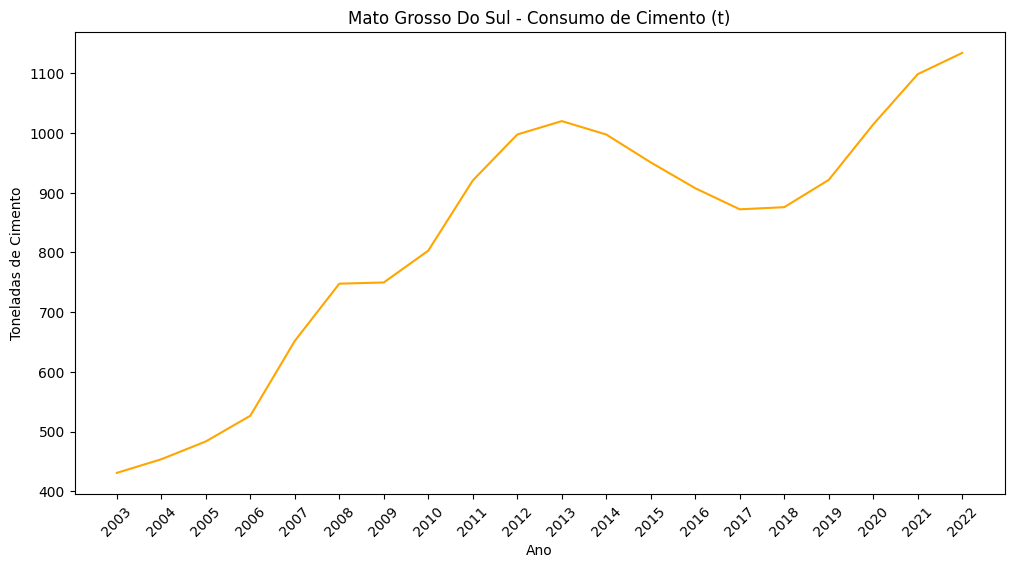

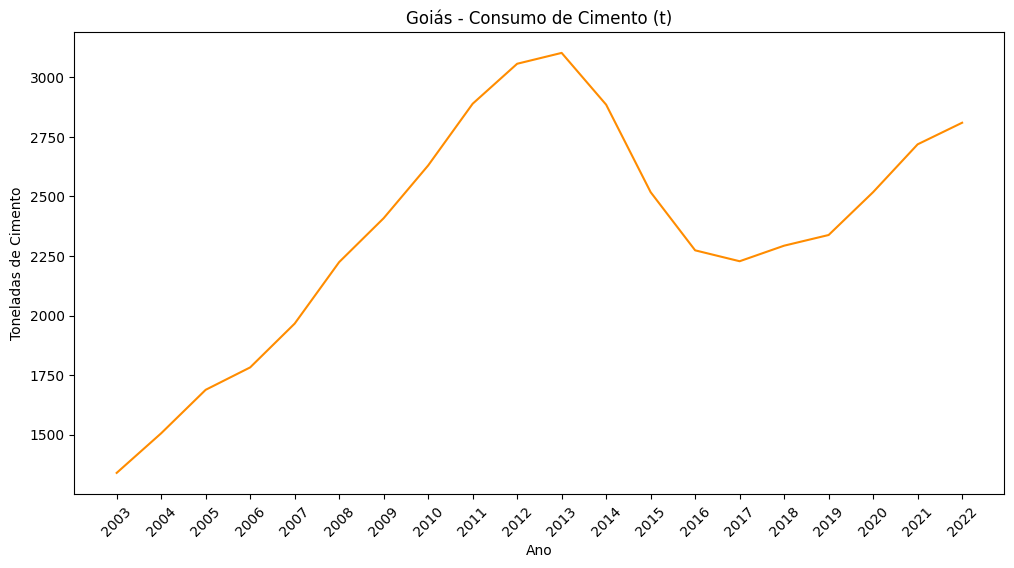

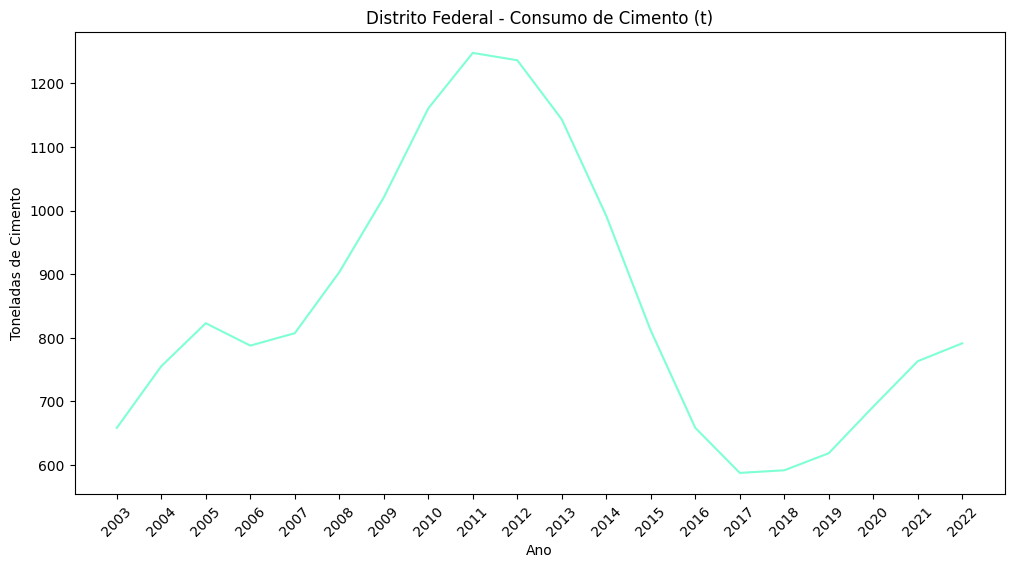

In [14]:
for i, column in enumerate(df_year.columns):
    if i > 1:
        plot_column(df_year[column], color=colors[i])